In [198]:
import os
import sklearn
import numpy as np
import pandas as pd
from numpy import unwrap, diff, abs, angle
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from sklearn.utils import shuffle
import scipy
from scipy.signal import butter, filtfilt, hilbert
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import skew, kurtosis
from scipy.signal import spectrogram
from mne.viz import plot_topomap
from scipy.signal import welch
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
import optuna
from sklearn.datasets import make_classification
from PIL import Image, ImageDraw, ImageFont
from joblib import dump
from scipy.signal import butter, filtfilt, lfilter, lfilter_zi
from sklearn.linear_model import SGDClassifier

#####################################################################################
selected_columns = ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'Po7', 'Oz', 'Po8']
fs=250

####################################################################################
#pre/processing functions

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def detrend(df, col_names):
    df_detrended = df.copy()
    for col in col_names:
        y = df_detrended[col]
        x = np.arange(len(y))
        p = np.polyfit(x, y, 1)
        trend = np.polyval(p, x)
        detrended = y - trend
        df_detrended[col] = detrended
    return df_detrended

def denoise_data(df, col_names, n_clusters):
    df_denoised = df.copy()
    for col_name, k in zip(col_names, n_clusters):
        df_denoised[col_name] = pd.to_numeric(df_denoised[col_name], errors='coerce') # Convert column to numeric format
        X = df_denoised.select_dtypes(include=['float64', 'int64']) # Select only numeric columns
        clf = KNeighborsRegressor(n_neighbors=k, weights='uniform') # Fit KNeighborsRegressor
        clf.fit(X.index.values[:, np.newaxis], X[col_name])
        y_pred = clf.predict(X.index.values[:, np.newaxis]) # Predict values 
        df_denoised[col_name] = y_pred
    return df_denoised

def z_score(df, col_names):
    df_standard = df.copy()
    for col in col_names:
        df_standard[col] = (df[col] - df[col].mean()) / df[col].std()
    return df_standard

def custom_detrend(df, col_names):
    df_detrended = df.copy()
    for col in col_names:
        y = df_detrended[col]
        x = np.arange(len(y))
        p = np.polyfit(x, y, 1)
        trend = np.polyval(p, x)
        detrended = y - trend
        df_detrended[col] = detrended
    return df_detrended

def preprocess(df, col_names, n_clusters):
    df_new = df.copy()
    df_new = denoise_data(df, col_names, n_clusters)
    # df_new = z_score(df_new, col_names)
    df_new = detrend(df_new, col_names)
    return df_new

def reject_artifacts(df, channel):
    threshold_factor = 3
    median = df[channel].median()
    mad = np.median(np.abs(df[channel] - median))
    spikes = np.abs(df[channel] - median) > threshold_factor * mad
    x = np.arange(len(df[channel]))
    cs = CubicSpline(x[~spikes], df[channel][~spikes]) # Interpolate using Cubic Spline
    interpolated_values = cs(x)
    interpolated_values[spikes] *= 0.01  # Make interpolated values 0.01 times smaller
    # Again Check each interpolated value's difference from median and compare to the threshold
    spike_values = np.abs(interpolated_values - median) > threshold_factor * mad
    interpolated_values[spike_values] *= 0.01 
    spike_values = np.abs(interpolated_values - median) > threshold_factor * mad
    interpolated_values[spike_values] *= 0.01 
    df[channel] = interpolated_values
    return df

#########################################################################################
current_directory = os.getcwd()
patient_data_folder = os.path.join(current_directory, "EMBC2024")

folder_name = input("Please enter the subject name: ")
Report_Number = input("Please enter the reprt number: ")
full_folder_path = os.path.join(patient_data_folder, folder_name)

# root_folder = "2-Patient Data"
sub_folders = ["Pre Evaluation", "Neurofeedback", "Post Evaluation"]
phase = int(input("Enter the phase (0, 1, 2): "))  # Or however you get the phase value
# Determine which sub-folders to use based on the phase
folders_to_use = []
if phase == 0:
    folders_to_use = [sub_folders[0]]  # Just "Pre Evaluation"
elif phase == 1:
    folders_to_use = sub_folders[:2]  # "Pre Evaluation" and "Neurofeedback"
elif phase == 2:
    folders_to_use = [sub_folders[2]]  # 


In [199]:
################################################################################################
#Notice that: base:2, face:0, scene:1
duration = 40 
raw=[]
event=[]
PP=[]
Human_Behavior=[]
eeg_processed=[]
for folder in folders_to_use:
    full_folder_path_ = os.path.join(full_folder_path, folder)
    if os.path.exists(full_folder_path_) and os.path.isdir(full_folder_path_):
        for file_name in os.listdir(full_folder_path_):
            if file_name.endswith('.csv') and (file_name.startswith('raw_eeg_block') or file_name.startswith('fl_') 
                                               or file_name.startswith('R') or file_name.startswith('B')):
                file_path = os.path.join(full_folder_path_, file_name)
                s_temp = pd.read_csv(file_path, header=None)
                
                inst_symbol = s_temp.iloc[:, 17]
                
                #Converting the labels to numbers
                inst=[]
                for i in range(len(inst_symbol)):
                    if 'g' in inst_symbol[i]  or 'b' in inst_symbol[i] :
                        inst.append(2)
                    if 'M' in inst_symbol[i]  or 'F' in inst_symbol[i] :
                        inst.append(0)
                    if 'O' in inst_symbol[i]  or 'I' in inst_symbol[i] :
                        inst.append(1) 
                
                HB=s_temp.iloc[1750:, 17:21]
                df_temp_eeg = s_temp.iloc[:, :8]
                Human_Behavior.append(HB)

                # 1. Band Pass
                raw_bp = np.copy(df_temp_eeg)
                for column in range(8):
                    raw_bp[:, column] = butter_bandpass_filter(raw_bp[:, column], lowcut=.4, highcut=40, fs=250) 
                
                # 2. Artifact rejection
                BP_artifact_RJ = np.copy(raw_bp)
                for channel in range (8):
                    BP_artifact_RJ= reject_artifacts(pd.DataFrame(BP_artifact_RJ), channel)
                
                # 3. Preprocessing: Denoise, Z-Score, Dtrend
                BP_artifact_RJ.columns = selected_columns
                eeg_df_denoised = preprocess(pd.DataFrame(BP_artifact_RJ), col_names=selected_columns, n_clusters=[10]*len(selected_columns))
                
                # I preprocessed the whole data in each block, then, split it to the base and the activity signal
                eeg_activity=eeg_df_denoised.iloc[1750:,]                
                
                #concate the labels to the processed data
                eeg_df_denoised_inst=pd.concat([eeg_df_denoised,pd.DataFrame(inst)], axis=1) 
                
                eeg_processed.append(eeg_df_denoised_inst) #all blocks processes eeg with instruction containing both base and activity signal
                #len(eeg_processed)= the number of blocks
                PP.append(eeg_activity)
    else:
        print(f"{full_folder_path_} does not exist")
        
block_number=len(eeg_processed)
print(block_number)

32


In [201]:
#baseline rejection
activity_baserejected_with_inst=[]
Total_base_rejected_with_inst=[]
face=[] #label=0
scene=[]#label=1, base label=2
instruction_of_activity=[]
event_=[]
for i in range (len(eeg_processed)):
    pp_data=eeg_processed[i]
    instruction = pp_data.iloc[:, 8]

    mask = pp_data.iloc[:, -1] == 2
    baseline = pp_data[mask].iloc[:, :-1]
    baseline_avg = baseline.mean()
    activity_data = pp_data[~mask]

    inst_activity=activity_data.iloc[:, 8]
    instruction_of_activity.append(inst_activity)
    
    adjusted_activity = activity_data.iloc[:, :-1] - baseline_avg
    adjusted_baseline = baseline - baseline_avg
    
    concatenated_base_activity = pd.concat([adjusted_baseline, adjusted_activity], ignore_index=True)
    pp_data_baseline_rejected= pd.concat([concatenated_base_activity, instruction], axis=1) #both activity ans base with labels
    
    activity_baseline_rejected_with_inst= pd.concat([adjusted_activity, inst_activity], axis=1)
    activity_baserejected_with_inst.append(activity_baseline_rejected_with_inst) #All the activity data and their labels
    
    Total_base_rejected_with_inst.append(pp_data_baseline_rejected) #All the data both activity ans base with labels
    
    # splitting the data to face and scene category
    if [1] in instruction.values :
        scene.append(pp_data_baseline_rejected) # has also the base            
    if [0] in instruction.values :
        face.append(pp_data_baseline_rejected)  # has also the base                       
    event_.append(instruction) # has also the base   
     
face_np=np.array(face) # has also the base with labels
scene_np=np.array(scene) # has also the base with labels
event_np=np.array(event_)

Total_base_rejected_with_inst_np=np.array(Total_base_rejected_with_inst) #All the data both activity ans base with labels
print(' Total_base_rejected_with_inst_np.shape:', Total_base_rejected_with_inst_np.shape, 'face_np.shape:', face_np.shape)

labels_np=np.array(instruction_of_activity)

#epoching the labels
label_final=labels_np.reshape(int(labels_np.shape[0]*labels_np.shape[1]/fs), fs)
label_final_np=np.array(label_final)
label_final_np_squeeze=np.squeeze(label_final_np[:,0]) 

 Total_base_rejected_with_inst_np.shape: (32, 11750, 9) face_np.shape: (16, 11750, 9)


In [7]:
# data_T = Total_base_rejected_with_inst_np #shape: (8, 11750, 9)
# print(data_T .shape)

(32, 11750, 9)


In [202]:
def z_score(df, col_names):
    df_standard = df.copy()
    for col in col_names:
        df_standard[col] = (df[col] - df[col].mean())/df[col].std()
    return df_standard

input_z_score= Total_base_rejected_with_inst_np.reshape( Total_base_rejected_with_inst_np.shape[0]* Total_base_rejected_with_inst_np.shape[1],  Total_base_rejected_with_inst_np.shape[2])
inst_zscore=input_z_score[:,-1]

input_z_score_df = pd.DataFrame(input_z_score[:,:-1], columns=selected_columns)

for channel in range(8):
    z_scored_data=z_score(input_z_score_df , col_names=selected_columns)

inst_zscore_2d=inst_zscore.reshape(inst_zscore.shape[0], 1)

z_scored_data_np=np.array(z_scored_data)
z_scored_data_np_inst=np.concatenate([z_scored_data_np, inst_zscore_2d], axis=1)
z_scored_data_reshape_inst=z_scored_data_np_inst.reshape(Total_base_rejected_with_inst_np.shape[0], Total_base_rejected_with_inst_np.shape[1], Total_base_rejected_with_inst_np.shape[2])
data_T =z_scored_data_reshape_inst

Signal Processing

In [203]:
#Wavelet
#functions
def morlet_wavelet(frequency, num_cycles, sampling_rate, duration=1):
    t = np.linspace(-duration/2, duration/2, int(sampling_rate * duration), endpoint=False)
    sine_wave = np.exp(2j * np.pi * frequency * t)
    amplitude_envelope = np.exp(-t**2 * (np.pi * frequency / num_cycles)**2)
    wavelet = sine_wave * amplitude_envelope
    return wavelet

def convolve_with_wavelet(data, wavelet):
    # Ensure data is in 2D form
    if data.ndim == 1:
        data = data[np.newaxis, :]
    n_signal = data.shape[1]
    n_wavelet = len(wavelet)
    n_convolution = n_signal + n_wavelet - 1

    data_fft = np.fft.fft(data, n_convolution, axis=1)
    wavelet_fft = np.fft.fft(wavelet, n_convolution)[np.newaxis, :]
    convolution_result_fft = data_fft * wavelet_fft
    convolution_result = np.fft.ifft(convolution_result_fft, axis=1)
    # Cut the data
    start = (n_wavelet - 1) // 2
    end = start + n_signal
    return convolution_result[:, start:end]
####################################################################################################################################

In [204]:
# Constants
frequencies = np.arange(0, 40, 1)  # 0 to 40 Hz
cycles = np.linspace(.1,10, len(frequencies))  # Variable cycles from 1 to 10
sampling_rate = 250
selected_columns = ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'Po7', 'Oz', 'Po8']

**Wavelet Transform Analysis**

In [205]:
#Wavelet_face analysis
data_f = face_np  
# Initialize a dictionary to store power matrices for each channel
power_matrices_f = {channel: [] for channel in selected_columns}

for channel_idx, channel_name in enumerate(selected_columns):
    # print('channel_name:', channel_name)
    for freq, cycle in zip(frequencies, cycles):
        power_blocks_base_corrected=[]
        for i in range (len(data_f)): #12
            data_f_i_np= data_f[i]
            # print('data_f_i_np.shape:', data_f_i_np.shape)
            data_f_i_np_t=np.transpose(data_f_i_np)

            # Extract one channel
            data_f_i_t = data_f_i_np_t[channel_idx, :]  # Trials are on the second dimension
            data_f_i_inst = data_f_i_np_t[8, :]
            # print('data_f_i_inst.shape:', data_f_i_inst.shape)
            wavelet = morlet_wavelet(freq, cycle, sampling_rate)
            convolution = convolve_with_wavelet(data_f_i_t , wavelet)    
            power = np.abs(convolution)**2

            data_f_i_inst_2d = data_f_i_inst[np.newaxis, :]
            # print('data_f_i_inst_2d.shape:', data_f_i_inst_2d.shape)
            power_with_inst=np.concatenate([power,data_f_i_inst_2d], axis=0)
            power_with_inst_t=np.transpose(power_with_inst)
            mask = (power_with_inst_t[:, 1] == 2) 
            base_l= power_with_inst_t[mask]
            base= base_l[:, :-1]
            # print(base.shape)
            mean_base= np.mean(base_l[:, :-1], axis=0)
            # print('mean_base', mean_base)
            
            activity = power_with_inst_t[~mask]
            # print('activity:' , activity )
            
            epoch_size = 250
            epochs = []
            for start in range(0, len(activity), epoch_size):
                end = start + epoch_size
                if end <= len(activity):
                    epochs.append(activity[start:end, :-1])
                else:
                    epochs.append(activity[start:,:-1])
                epochs_np=np.array(epochs)
                
            activity_mean_epochs = np.mean(epochs_np, axis=0)
            # print('activity_mean_epochs.shape:', activity_mean_epochs.shape) #(250, 1)
            normalized=activity_mean_epochs/mean_base 
            
            #baseline normalization
            nb_e=[]
            for i in range (epochs_np.shape[0]):
                nb_b_e=[]
                for j in range (epochs_np.shape[1]):
                    # print(normalized[j], epochs_np[i, j,:]/mean_base)
                    vector1 = epochs_np[i, j,:]
                    vector2 =activity_mean_epochs[j]
                    result_vector = vector1 #(4*vector1+vector2)/5
                    # print(normalized[j], epochs_np[i, j,:]/mean_base)
                    nbej=10*np.log10(float(result_vector/mean_base))                    
                    nb_b_e.append(nbej)
                nb_e.append(nb_b_e)
            nb_e_np=np.array(nb_e)
            nb=np.mean( nb_e_np, axis=0)
            baseline_normalized=np.array(nb)
           
            power_blocks_base_corrected.append(baseline_normalized)
            # power_blocks_base_corrected_np= np.array(power_blocks_base_corrected)
        power_blocks_base_corrected_np_mean_f=np.mean(power_blocks_base_corrected, axis=0)
        # print('power_blocks_base_corrected_np_mean', power_blocks_base_corrected_np_mean_f.shape)
        power_matrices_f[channel_name].append(power_blocks_base_corrected_np_mean_f)

In [206]:
#Wavelet_Scene Analysis
data_s = scene_np  
power_matrices_s = {channel: [] for channel in selected_columns}

for channel_idx, channel_name in enumerate(selected_columns):
    for freq, cycle in zip(frequencies, cycles):
        power_blocks_base_corrected=[]
        for i in range (len(data_s)): #12
            data_s_i_np= data_s[i]
            data_s_i_np_t=np.transpose(data_s_i_np)

            data_s_i_t = data_s_i_np_t[channel_idx, :]  # Trials are on the second dimension
            data_s_i_inst = data_s_i_np_t[8, :]
            wavelet = morlet_wavelet(freq, cycle, sampling_rate)
            convolution = convolve_with_wavelet(data_s_i_t , wavelet)    
            power = np.abs(convolution)**2

            data_s_i_inst_2d = data_s_i_inst[np.newaxis, :]
            power_with_inst=np.concatenate([power,data_s_i_inst_2d], axis=0)
            power_with_inst_t=np.transpose(power_with_inst)
            mask = (power_with_inst_t[:, 1] == 2)
            base_l= power_with_inst_t[mask]
            base= base_l[:, :-1]
            # print(base.shape)
            mean_base= np.mean(base_l[:, :-1], axis=0)
            # print('mean_base', mean_base)
            
            activity = power_with_inst_t[~mask]
            
            epoch_size = 250
            epochs = []
            for start in range(0, len(activity), epoch_size):
                end = start + epoch_size
                if end <= len(activity):
                    epochs.append(activity[start:end, :-1])
                else:
                    epochs.append(activity[start:,:-1])
                epochs_np=np.array(epochs)
            # print(epochs_np.shape)
            
            activity_mean_epochs = np.mean(epochs_np, axis=0)
            # print('activity_mean_epochs.shape:', activity_mean_epochs.shape) #(250, 1)
            normalized=activity_mean_epochs/mean_base 
            
            #baseline normalization
            nb_e=[]
            for i in range (epochs_np.shape[0]):
                nb_b_e=[]
                for j in range (epochs_np.shape[1]):
                    vector1 = epochs_np[i, j,:]
                    vector2 = activity_mean_epochs[j]
                    result_vector = vector1
                    # print(normalized[j], epochs_np[i, j,:]/mean_base)
                    nbej=10*np.log10(float(result_vector/mean_base))
                    nb_b_e.append(nbej)
                nb_e.append(nb_b_e)
            
            nb_e_np=np.array(nb_e)
            
            nb=np.mean( nb_e_np, axis=0)

            baseline_normalized=np.array(nb)
            # print('baseline_normalized.shape:', baseline_normalized.shape)
            power_blocks_base_corrected.append(baseline_normalized)
        power_blocks_base_corrected_np_mean_s=np.mean(power_blocks_base_corrected, axis=0)
        # print('power_blocks_base_corrected_np_mean', power_blocks_base_corrected_np_mean_s.shape)
        power_matrices_s[channel_name].append(power_blocks_base_corrected_np_mean_s)
        

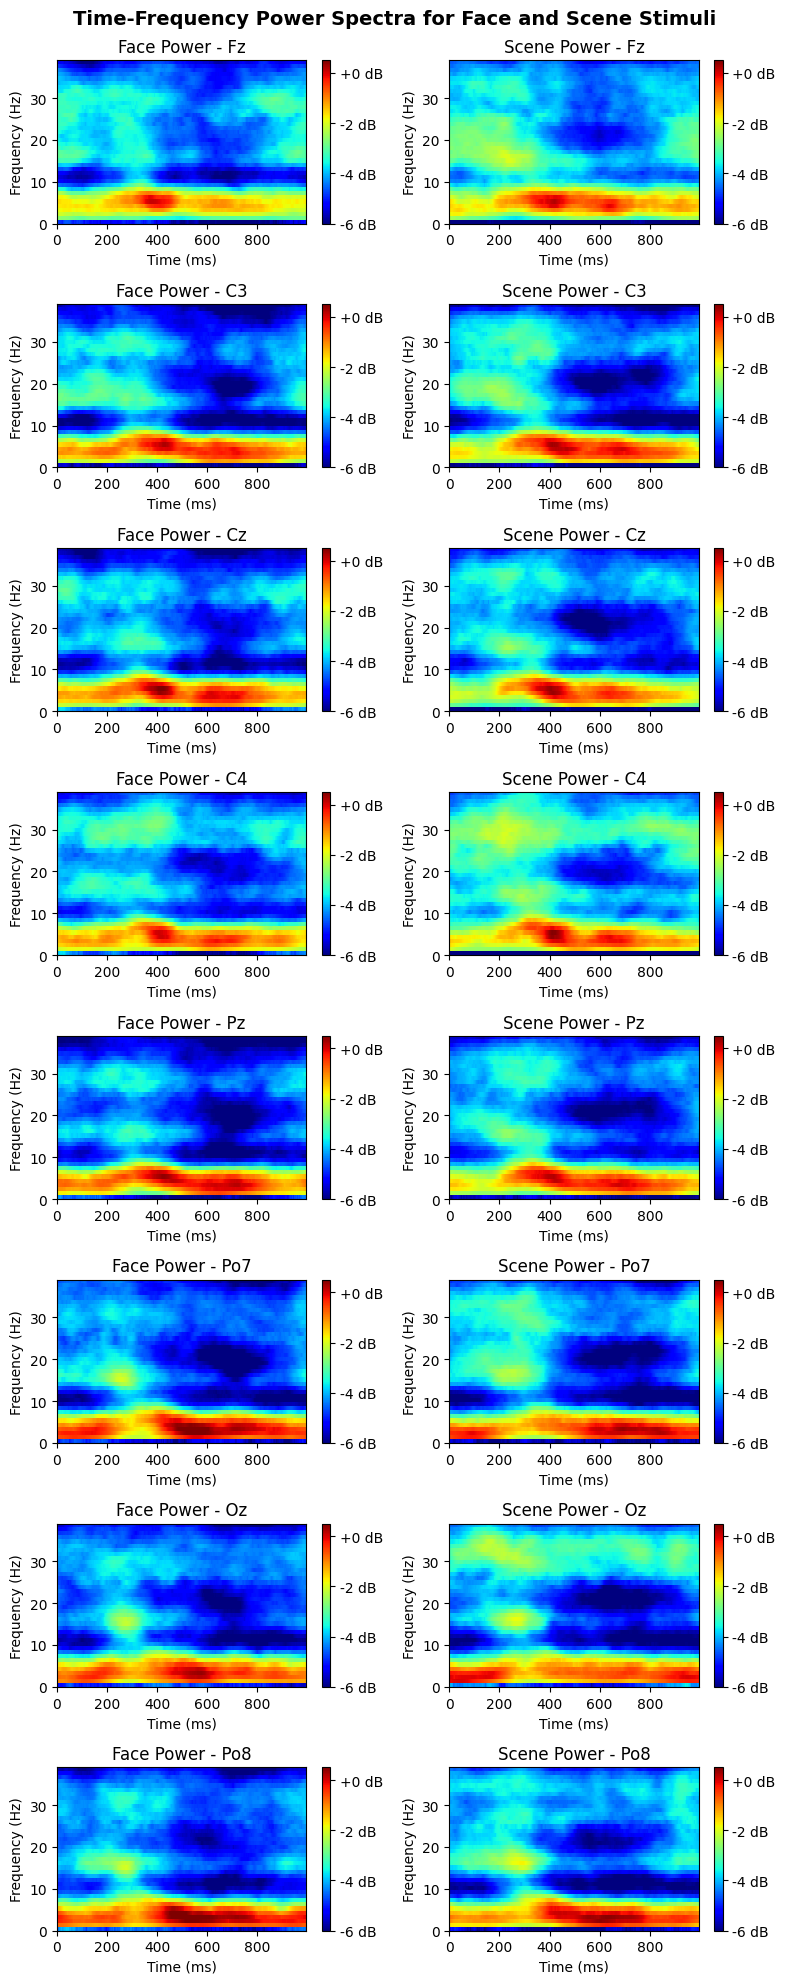

In [72]:
# def plot_time_frequency(data, title, ax):
#     data_to_plot = data # Transpose and Log transform of power; add a small constant to avoid log(0)
#     img = ax.imshow(data_to_plot, aspect='auto', cmap='jet', origin='lower',
#                     extent=[times[0], times[-1], frequencies[0], frequencies[-1]],vmin=-6, vmax=0.5) #vmin=-6, vmax=2
#     fig.colorbar(img, ax=ax, format='%+2.0f dB')  # Use fig.colorbar to specify the axes
#     ax.set_xlabel('Time (ms)')
#     ax.set_ylabel('Frequency (Hz)')
#     ax.set_title(title)    
# n_channels = 8   

# # Calculate the sampling interval
# sampling_interval = 1 / 250  
# times = np.arange(0, 1, step=sampling_interval)
# times = times * 1000  
 
# fig, axs = plt.subplots( n_channels, 2, figsize=(8,20))  # Adjust figsize as needed

# fig.suptitle('Time-Frequency Power Spectra for Face and Scene Stimuli', y=0.990, fontsize=14, weight='bold') 
  
# for i, channel in enumerate(selected_columns):
#     df_face =power_matrices_f[channel]
#     df_scene =power_matrices_s[channel]
#     # Convert DataFrame to numpy array
#     face_power_matrix = np.array(df_face)
#     scene_power_matrix =np.array(df_scene) 

#     # Use the data from the 50th sample point to 300th
#     face_power_matrix_reduced = face_power_matrix
#     scene_power_matrix_reduced = scene_power_matrix

#     # Plot the results for face and scene
#     plot_time_frequency(face_power_matrix_reduced, f'Face Power - {channel}', axs[i ,0])
#     plot_time_frequency(scene_power_matrix_reduced, f'Scene Power - {channel}', axs[i, 1])
# plt.tight_layout()
# plt.show()

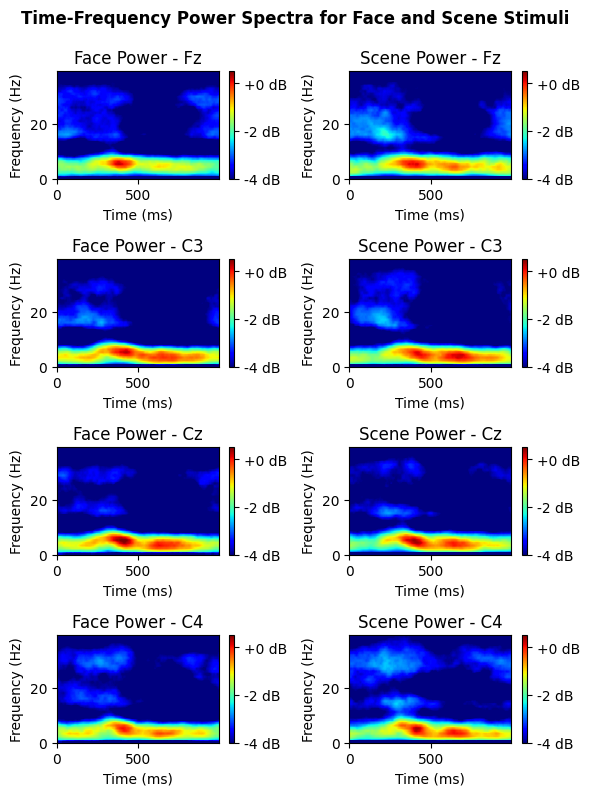

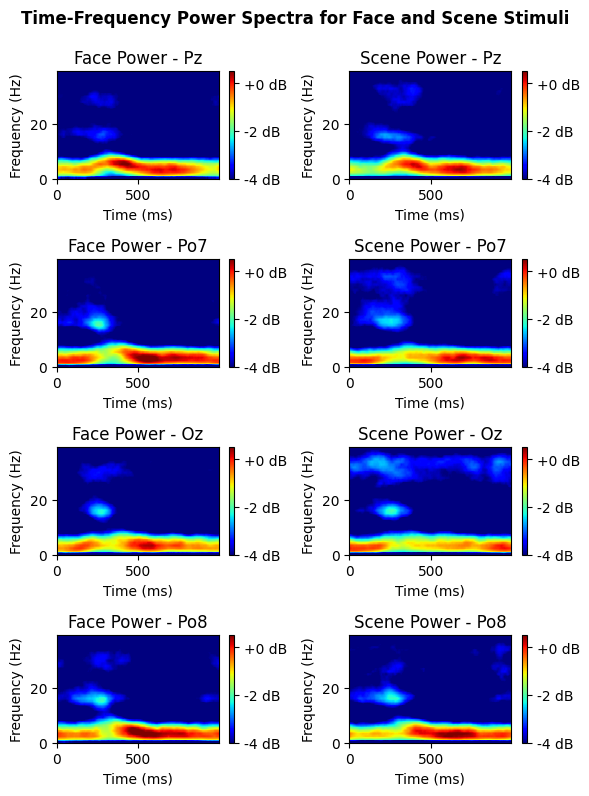

In [207]:
import numpy as np
import matplotlib.pyplot as plt

def plot_time_frequency(data, title, ax):
    # Assuming data_to_plot is correctly calculated before this function
    data_to_plot = data # Transpose and Log transform of power; add a small constant to avoid log(0)
    img = ax.imshow(data_to_plot, aspect='auto', cmap='jet', origin='lower',
                    extent=[times[0], times[-1], frequencies[0], frequencies[-1]], vmin=-4, vmax=0.5)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_title(title)

n_channels = 8
# Assuming 'frequencies' is defined somewhere in the code

# Calculate the sampling interval
sampling_interval = 1 / 250
times = np.arange(0, 1, step=sampling_interval)
times = times * 1000

# Assuming 'selected_columns' is a list of channel names and 'power_matrices_f' and 'power_matrices_s' are defined

# Split the plotting into two sets of channels
for set_number in range(2):
    fig, axs = plt.subplots(4, 2, figsize=(6, 8))  # 4 rows, 2 columns for each set
    fig.suptitle(f'Time-Frequency Power Spectra for Face and Scene Stimuli', y=0.990, fontsize=12, weight='bold')
    
    for i in range(4):
        channel_index = set_number * 4 + i  # Calculate the channel index
        channel = selected_columns[channel_index]
        df_face = power_matrices_f[channel]
        df_scene = power_matrices_s[channel]

        # Convert DataFrame to numpy array
        face_power_matrix = np.array(df_face)
        scene_power_matrix = np.array(df_scene)

        # Plot the results for face and scene
        plot_time_frequency(face_power_matrix, f'Face Power - {channel}', axs[i, 0])
        plot_time_frequency(scene_power_matrix, f'Scene Power - {channel}', axs[i, 1])
    
    plt.tight_layout()
    plt.show()


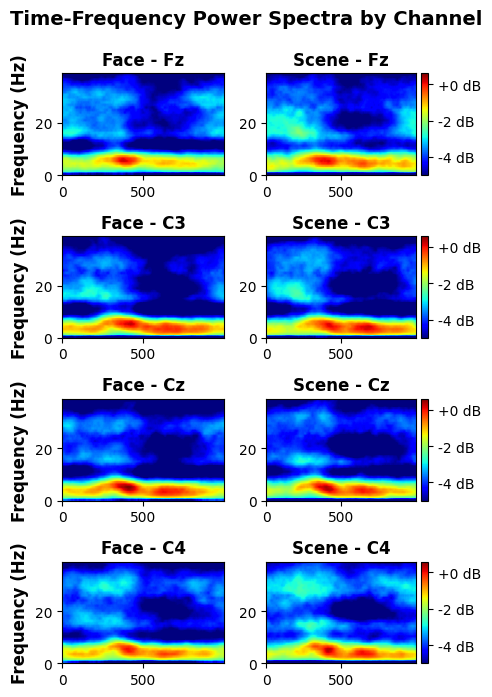

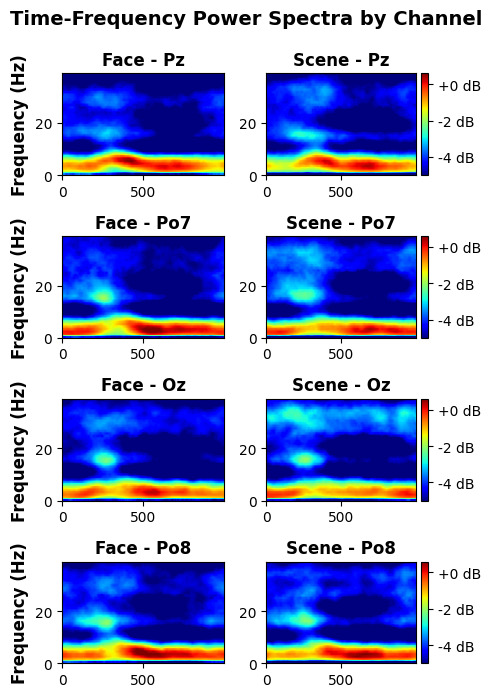

In [224]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# def plot_time_frequency(data, title, ax, show_colorbar=False):
#     # Plot the data
#     img = ax.imshow(data, aspect='auto', cmap='jet', origin='lower',
#                     extent=[times[0], times[-1], frequencies[0], frequencies[-1]], vmin=-5, vmax=.6)
#     ax.set_title(title)

#     # Add colorbar to the rightmost subplot
#     if show_colorbar:
#         divider = make_axes_locatable(ax)
#         cax = divider.append_axes("right", size="5%", pad=0.05)
#         plt.colorbar(img, cax=cax, format='%+2.0f dB')
def plot_time_frequency(data, title, ax, show_colorbar=False):
    # Plot the data
    img = ax.imshow(data, aspect='auto', cmap='jet', origin='lower',
                    extent=[times[0], times[-1], frequencies[0], frequencies[-1]], vmin=-5, vmax=.6)
    ax.set_title(title, weight='bold')  # Make the title bold

    # Add colorbar to the rightmost subplot
    if show_colorbar:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(img, cax=cax, format='%+2.0f dB')


for set_number in range(2):
    fig, axs = plt.subplots(4, 2, figsize=(5, 7))
    fig.suptitle(f'Time-Frequency Power Spectra by Channel', y=0.990, fontsize=14, weight='bold')

    for i in range(4):
        channel_index = set_number * 4 + i
        channel = selected_columns[channel_index]
        face_power_matrix = np.array(power_matrices_f[channel])
        scene_power_matrix = np.array(power_matrices_s[channel])

        plot_time_frequency(face_power_matrix, f'Face - {channel}', axs[i, 0])
        axs[i, 0].set_ylabel('Frequency (Hz)', fontsize=12, weight='bold')  # Set y-axis title on the leftmost plot
        plot_time_frequency(scene_power_matrix, f'Scene - {channel}', axs[i, 1], show_colorbar=True)

    plt.tight_layout()
    plt.show()


**ERP Analysis**

In [82]:
#ERP
# Band Pass
scene_bp = np.copy(scene_np)
face_bp = np.copy(face_np)
for i in range (len(scene_np)):
    for column in range(8):
        scene_bp[i,:, column] = butter_bandpass_filter(scene_bp[i,:, column], lowcut=1, highcut=4, fs=250)
        face_bp[i,:, column] = butter_bandpass_filter(face_bp[i,:, column], lowcut=1, highcut=4, fs=250)        

#Scene
data_s = scene_bp 
ERP_s = {channel: [] for channel in selected_columns}
Base_s={channel: [] for channel in selected_columns}

for channel_idx, channel_name in enumerate(selected_columns):
    blocks_erp_acticity = []
    blocks_erp_base=[]
    for i in range (len(data_s)): 
        data_erp= data_s[i]
        data_erp_t=np.transpose(data_erp)
        data_erp_inst = data_erp_t[8, :]
        # Extract one channel
        data_i_erp_t = data_erp_t[channel_idx, :] # Trials are on the second dimension
        data_i_erp_inst=np.vstack((data_i_erp_t, data_erp_inst))
        # print(data_i_erp_inst.shape)
        mask = (data_i_erp_inst[1, :] == 2)
        
        base_i= data_i_erp_inst[:, mask]
        base_i_data= base_i[0, :]
        
        activity_i= data_i_erp_inst[:,~mask]
        activity_i_data= activity_i[0, :]
        # print(activity_i_data.shape[0])
        
        activity_i_downsample=activity_i_data.reshape(int(activity_i_data.shape[0]/250),50,5)
        base_i_downsample=base_i_data.reshape(int(base_i_data.shape[0]/250),50,5)
        
        activity_i_mean=activity_i_downsample.mean(axis=2)
        base_i_mean=base_i_downsample.mean(axis=2)
        
        block_acticity=activity_i_mean.mean(axis=0)
        block_base=base_i_mean.mean(axis=0)
        # print( block_acticity.shape, block_base.shape)
        blocks_erp_acticity.append(block_acticity)
        blocks_erp_acticity_mean=np.mean(blocks_erp_acticity, axis=0)
        blocks_erp_base.append(block_base)
        blocks_erp_base_mean=np.mean(blocks_erp_base, axis=0)
        # print(len(blocks_erp_acticity_mean))
    ERP_s[channel_name].append(blocks_erp_acticity_mean)
    Base_s[channel_name].append(blocks_erp_base_mean)
    
#Face
data_f = face_bp 
ERP_f = {channel: [] for channel in selected_columns}
Base_f={channel: [] for channel in selected_columns}

for channel_idx, channel_name in enumerate(selected_columns):
    blocks_erp_acticity = []
    blocks_erp_base=[]
    for i in range (len(data_f)): 
        data_erp= data_f[i]
        data_erp_t=np.transpose(data_erp)
        data_erp_inst = data_erp_t[8, :]
        data_i_erp_t = data_erp_t[channel_idx, :] 
        data_i_erp_inst=np.vstack((data_i_erp_t, data_erp_inst))
        mask = (data_i_erp_inst[1, :] == 2)
        
        base_i= data_i_erp_inst[:, mask]
        base_i_data= base_i[0, :]
        
        activity_i= data_i_erp_inst[:,~mask]
        activity_i_data= activity_i[0, :]
        
        activity_i_downsample=activity_i_data.reshape(int(activity_i_data.shape[0]/250),50,5)
        base_i_downsample=base_i_data.reshape(int(base_i_data.shape[0]/250),50,5)
        
        activity_i_mean=activity_i_downsample.mean(axis=2)
        base_i_mean=base_i_downsample.mean(axis=2)
        
        block_acticity=activity_i_mean.mean(axis=0)
        block_base=base_i_mean.mean(axis=0)
        blocks_erp_acticity.append(block_acticity)
        blocks_erp_acticity_mean=np.mean(blocks_erp_acticity, axis=0)
        blocks_erp_base.append(block_base)
        blocks_erp_base_mean=np.mean(blocks_erp_base, axis=0)
    ERP_f[channel_name].append(blocks_erp_acticity_mean)
    Base_f[channel_name].append(blocks_erp_base_mean)
    
#######################################################################################################################
array_face = np.array(list(ERP_f.values()))
squeezed_array_face = np.squeeze(array_face, axis=1).T
# print(squeezed_array_face.shape)

array_scene = np.array(list(ERP_s.values()))
squeezed_array_scene = np.squeeze(array_scene, axis=1).T
# print(squeezed_array_scene.shape)

face_base = np.array(list(Base_f.values()))
scene_base = np.array(list(Base_s.values()))


In [ ]:
face_base_squeeze=np.squeeze(face_base , axis=1).T   #(50, 8)
scene_base_squeeze=np.squeeze(scene_base , axis=1).T  #(50, 8)
# mean_base = (face_base_squeeze + scene_base_squeeze) / 2.0

epoch_size_base =25
epochs_base_face = []
for start in range(0,50, epoch_size_base):
    end = start + epoch_size_base
    if end <= 50:
        epochs_base_face.append(face_base_squeeze[start:end, :])
    else:
        epochs_base_face.append(face_base_squeeze[start:,:])

epochs_base_np_face=np.array(epochs_base_face)
epochs_base_np_mean_face=np.mean(epochs_base_np_face, axis=0)

epoch_size_base =25
epochs_base_scene = []
for start in range(0,50, epoch_size_base):
    end = start + epoch_size_base
    if end <= 50:
        epochs_base_scene.append(scene_base_squeeze[start:end, :])
    else:
        epochs_base_scene.append(scene_base_squeeze[start:,:])

epochs_base_np_scene=np.array(epochs_base_scene)
epochs_base_np_mean_scene=np.mean(epochs_base_np_scene, axis=0)

time_list = []
for n in range(50):
    time = (n*5)/(250)
    time_list.append(time)
    
from scipy.ndimage import gaussian_filter1d

extended_time_list = [-time_list[1] * (int(epoch_size_base)- i) for i in range(int(epoch_size_base))] + time_list
print('len(extended_time_list):', len(extended_time_list))


plt.figure(figsize=(4, 20))
plt.suptitle('Average Neural Response by Channel', y=0.990, fontsize=14, weight='bold')

for channel in range(8):
    plt.subplot(8, 1, channel + 1)

    smoothed_face = gaussian_filter1d(np.concatenate([epochs_base_np_mean_face[:, channel], squeezed_array_face[:, channel]]), sigma=.7)
    smoothed_scene = gaussian_filter1d(np.concatenate([epochs_base_np_mean_scene[:, channel], squeezed_array_scene[:, channel]]), sigma=.7) 
    
    # smoothed_face = np.concatenate([epochs_base_np_mean[:, channel], squeezed_array_face[:, channel]])
    # smoothed_scene = np.concatenate([epochs_base_np_mean[:, channel], squeezed_array_scene[:, channel]])                                  
    
    plt.plot(extended_time_list, smoothed_scene, label='Scene', linewidth=2)
    plt.plot(extended_time_list, smoothed_face, label='Face', linewidth=2)
    
    # Add vertical lines
    plt.axvline(x=0.000, color='black', linestyle='--')
    # plt.axvline(x=0.050, color='grey', linestyle='--')
    
    # plt.axvline(x=0.080, color='r', linestyle='--')
    # plt.axvline(x=0.210, color='r', linestyle='--')
    
    # plt.axvline(x=0.240, color='g', linestyle='--')
    # plt.axvline(x=0.350, color='g', linestyle='--')
    
    # plt.axvline(x=0.400, color='r', linestyle='--')
    # plt.axvline(x=0.500, color='r', linestyle='--')
    
    # plt.axvline(x=0.520, color='b', linestyle='--')
    # plt.axvline(x=0.630, color='b', linestyle='--')
    
    # plt.axvline(x=0.650, color='y', linestyle='--')
    # plt.axvline(x=0.900, color='y', linestyle='--')


    
    plt.title(selected_columns[channel], fontsize=14, weight='bold')
    plt.xlabel('Time (s)', fontsize=12, weight='bold')
    plt.ylabel('Volt (µV)', fontsize=12, weight='bold')
    plt.xticks(fontsize=10, weight='bold')
    plt.yticks(fontsize=10, weight='bold')
    plt.legend(fontsize=6.5)

plt.tight_layout()
plt.show()


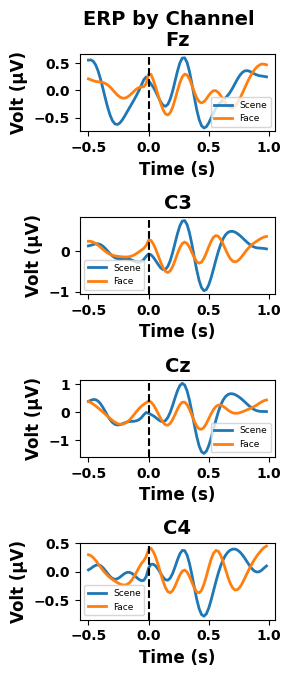

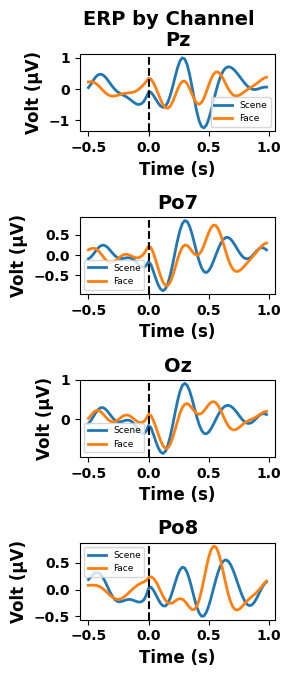

In [242]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Split the plotting into two sets of channels
for set_number in range(2):
    plt.figure(figsize=(3, 7))
    plt.suptitle(f'ERP by Channel', y=0.960,x=0.580, fontsize=14, weight='bold')
    
    for i in range(4):
        channel_index = set_number * 4 + i  # Calculate the channel index
        plt.subplot(4, 1, i + 1)

        smoothed_face = gaussian_filter1d(
            np.concatenate([epochs_base_np_mean_face[:, channel_index], squeezed_array_face[:, channel_index]]), 
            sigma=.7
        )
        smoothed_scene = gaussian_filter1d(
            np.concatenate([epochs_base_np_mean_scene[:, channel_index], squeezed_array_scene[:, channel_index]]), 
            sigma=.7
        )

        plt.plot(extended_time_list, smoothed_scene, label='Scene', linewidth=2)
        plt.plot(extended_time_list, smoothed_face, label='Face', linewidth=2)

        plt.axvline(x=0.000, color='black', linestyle='--')
        plt.title(selected_columns[channel_index], fontsize=14, weight='bold')
        plt.xlabel('Time (s)', fontsize=12, weight='bold')
        plt.ylabel('Volt (µV)', fontsize=12, weight='bold')
        plt.xticks(fontsize=10, weight='bold')
        plt.yticks(fontsize=10, weight='bold')
        plt.legend(fontsize=6.5)
    
    plt.tight_layout()
    plt.show()


**Envelop Hilbert Analysis**

In [88]:
#Envelop Hilbert
from scipy.signal import hilbert

fs=250
frequency_bands = {
    'delta': (1, 4),
    'theta': (4, 8),
    'alpha': (8, 14),
    'beta': (14, 30),
    'gamma': (30, 40)}

baseline_epochs=7
epoch_length=250

#face
data_s=face_np
hilbert_f=[]
for channel_idx, channel_name in enumerate(selected_columns):
    hil_block=[]
    for block_index in range(len(scene_np)):
        f_band_env=[]
        f_band=[]
        for band, (lowcut, highcut) in frequency_bands.items():
            data = data_s[block_index, :, channel_idx]
            data_band= butter_bandpass_filter(data, lowcut, highcut, fs, order=5)
            envelope_abs = np.abs(hilbert(data_band))
            envelope=(envelope_abs)**1
            # Split into epochs and calculate mean of activity epochs
            epochs = np.split(envelope,envelope.shape[0] // epoch_length)
            mean_activity_epoch = np.mean(epochs[baseline_epochs:], axis=0)

            f_band_env.append(mean_activity_epoch)
        hil_block.append(f_band_env)   
    hilbert_f.append(hil_block)

hilbert_f_np=np.array(hilbert_f)
print(hilbert_f_np.shape ) #(8, 4, 5, 250)

#scene
data_s=scene_np
hilbert_s=[]
for channel_idx, channel_name in enumerate(selected_columns):
    hil_block=[]
    for block_index in range(len(scene_np)):
        s_band_env=[]
        s_band=[]
        for band, (lowcut, highcut) in frequency_bands.items():
            data = data_s[block_index, :, channel_idx]
            data_band= butter_bandpass_filter(data, lowcut, highcut, fs, order=5)
            envelope_abs = np.abs(hilbert(data_band))
            envelope=(envelope_abs)**1
            # Split into epochs and calculate mean of activity epochs
            epochs = np.split(envelope,envelope.shape[0] // epoch_length)
            mean_activity_epoch = np.mean(epochs[baseline_epochs:], axis=0)
           
            s_band_env.append(mean_activity_epoch)
        hil_block.append(s_band_env)   
    hilbert_s.append(hil_block)

hilbert_s_np_=np.array(hilbert_s)

hilbert_s_np_mean=np.mean(hilbert_s_np_, axis=1)
hilbert_f_np_mean=np.mean(hilbert_f_np, axis=1)


print(hilbert_f_np_mean.shape)

(8, 12, 5, 250)
(8, 5, 250)


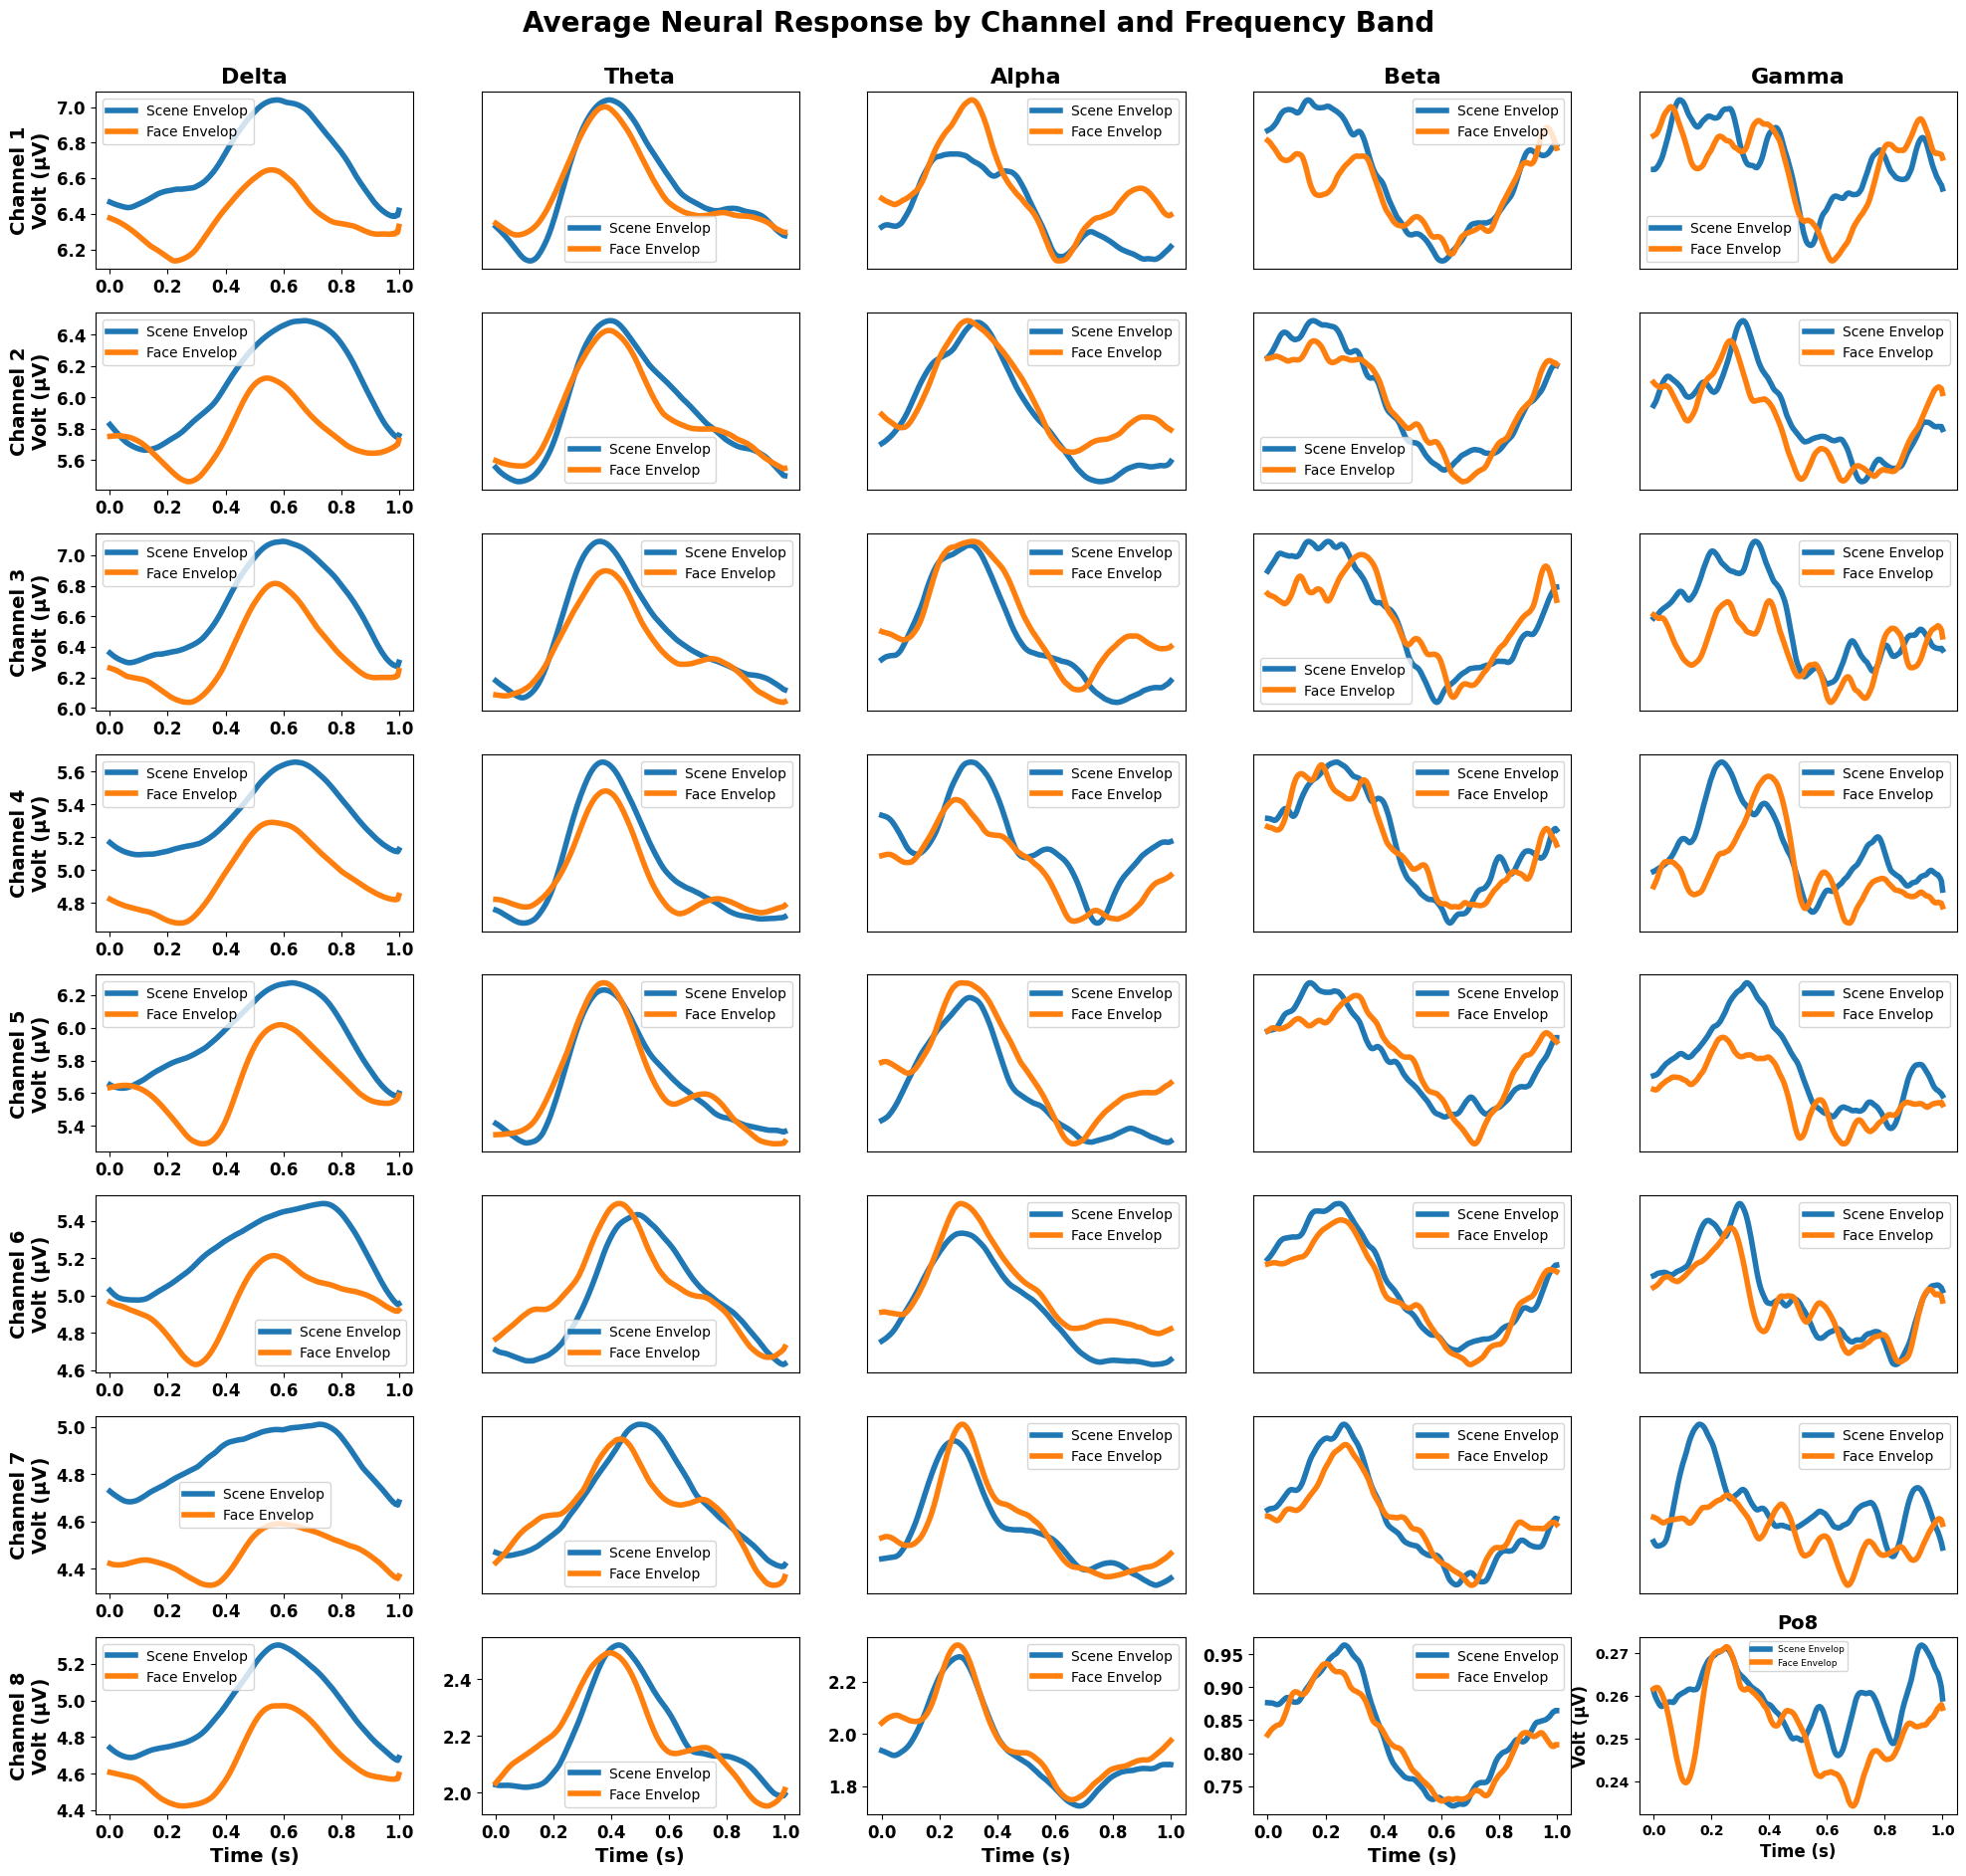

In [89]:
import matplotlib.pyplot as plt
import numpy as np

# Epoch_length is defined and equals 250
epoch_length = 250  
t = np.linspace(0, epoch_length / 250, epoch_length)

# Define the frequency band names for titles
frequency_band_names = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']

# Define a large enough figure size to accommodate 8x5 subplots
plt.figure(figsize=(20, 20))  # Adjust the size as needed
plt.suptitle('Average Neural Response by Channel and Frequency Band', y=.9702, fontsize=20, weight='bold')

# Loop over channels and frequency bands
for channel in range(8):
    for band in range(5):
        # Calculate subplot index
        subplot_idx = channel * 5 + band + 1
        plt.subplot(8, 5, subplot_idx)
        
        # Plot the envelopes and raw signals for each channel and band
        
        plt.plot(t, hilbert_s_np_mean[channel, band, :], label='Scene Envelop', linewidth=4)
        plt.plot(t, hilbert_f_np_mean[channel, band, :], label='Face Envelop', linewidth=4)

        # Set the title for each subplot with channel and frequency band information
        if band == 0:
            plt.ylabel(f'Channel {channel + 1}\nVolt (µV)', fontsize=14, weight='bold')
        
        if channel == 0:
            plt.title(frequency_band_names[band], fontsize=16, weight='bold')
        
        # Only show x label on the bottom row and y label on the first column
        if channel == 7:
            plt.xlabel('Time (s)', fontsize=14, weight='bold')
        
        # Set ticks properties only for the outer plots to avoid clutter
        if channel == 7 or band == 0:
            plt.xticks(fontsize=12, weight='bold')
            plt.yticks(fontsize=12, weight='bold')
        else:
            plt.xticks([])
            plt.yticks([])
        
        # if channel == 0 and band == 0:
        plt.legend(fontsize=10)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.title(selected_columns[channel], fontsize=14, weight='bold')
plt.xlabel('Time (s)', fontsize=12, weight='bold')
plt.ylabel('Volt (µV)', fontsize=12, weight='bold')
plt.xticks(fontsize=10, weight='bold')
plt.yticks(fontsize=10, weight='bold')
plt.legend(fontsize=6.5)
# Show plot
plt.show()


In [117]:
# data_T =z_scored_data_reshape_inst #shape: (8, 11750, 9)
# print(data_T .shape)

(24, 11750, 9)


In [134]:
#Feature Extraction
#Wavelet
####################################################################################################################################
# Constants
# frequencies = np.arange(0,40,1)  # 0 to 40 Hz
# cycles = np.linspace(1, 8, len(frequencies))  # Variable cycles from 1 to 10
# sampling_rate = 250
selected_columns = ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'Po7', 'Oz', 'Po8']
data_T = Total_base_rejected_with_inst_np #shape: (32, 11750, 9)

# Initialize a dictionary to store power matrices for each channel
power_matrices_T = {channel: [] for channel in selected_columns}

for channel_idx, channel_name in enumerate(selected_columns):
    for freq, cycle in zip(frequencies, cycles):
        power_blocks_base_corrected=[]
        for i in range (len(data_T)): #8
            data_T_i_np= data_T[i]
            data_T_i_np_t=np.transpose(data_T_i_np)

            # Extract one channel
            data_T_i_t = data_T_i_np_t[channel_idx, :]  # Trials are on the second dimension
            data_T_i_inst = data_T_i_np_t[8, :]
            wavelet = morlet_wavelet(freq, cycle, sampling_rate)
            convolution = convolve_with_wavelet(data_T_i_t , wavelet)    
            power = np.abs(convolution)**2

            data_T_i_inst_2d = data_T_i_inst[np.newaxis, :]
            power_with_inst=np.concatenate([power,data_T_i_inst_2d], axis=0)
            power_with_inst_t=np.transpose(power_with_inst)
            mask = (power_with_inst_t[:, 1] == 2)
            base_l= power_with_inst_t[mask]
            base= base_l[:, :-1]
            # print(base.shape)
            mean_base= np.mean(base_l[:, :-1], axis=0)
            # print('mean_base', mean_base)
            
            activity = power_with_inst_t[~mask]            
            epoch_size = 250
            epochs = []
            for start in range(0, len(activity), epoch_size):
                end = start + epoch_size
                if end <= len(activity):
                    epochs.append(activity[start:end, :-1])
                else:
                    epochs.append(activity[start:,:-1])
                epochs_np=np.array(epochs)
            # print('epochs_np', epochs_np.shape)
            
            activity_mean_epochs = np.mean(epochs_np, axis=0)
            # print('activity_mean_epochs.shape:', activity_mean_epochs.shape) #(250, 1)
            normalized=activity_mean_epochs/mean_base 
            
            #baseline normalization
            nb_e=[]
            for i in range (epochs_np.shape[0]):
                nb_b_e=[]
                for j in range (epochs_np.shape[1]):
                    vector1 = epochs_np[i, j,:]
                    vector2 =activity_mean_epochs[j]
                    result_vector = vector1 #(4*vector1+vector2)/5
                    # print(normalized[j], epochs_np[i, j,:]/mean_base)
                    nbej=10*np.log10(float(result_vector/mean_base))
                    # nbej=10*np.log10(float(1.2*normalized[j]+.5*epochs_np[i, j,:]/mean_base))
                    nb_b_e.append(nbej)
                nb_e.append(nb_b_e)
            nb_e_np=np.array(nb_e)
            baseline_normalized=nb_e_np
            # print(baseline_normalized.shape)
            power_blocks_base_corrected.append(baseline_normalized)
        power_matrices_T[channel_name].append(power_blocks_base_corrected)    
        ###############################################################################################################################################################
np.array(power_matrices_T['C3']).shape    

(40, 8, 40, 250)

In [135]:
from scipy.signal import find_peaks

for channel_idx, channel_name in enumerate(selected_columns):
    # print(channel_name)
    wavelet_coefficient_np=np.array(power_matrices_T[channel_name])
    # print(wavelet_coefficient_np.shape)
    reshaped_np = wavelet_coefficient_np.transpose(1, 2, 3, 0).reshape(int(wavelet_coefficient_np.shape[1] * 40), 250, 40)
    # Checking the new shape
    # print(reshaped_np.shape) #(960, 250, 40)
    
    
# Initialize the final numpy array to store the features for each input and each channel
num_inputs = reshaped_np.shape[0]
num_channels = 8  # As mentioned, assuming there are 8 channels
num_features = 7  # Total number of features

# The final shape will be (number of inputs, number of channels, number of features)
wavelet_feature_array = np.zeros((num_inputs, num_channels, num_features))

# Function to calculate entropy
def calculate_entropy(data):
    prob_dist = data / np.sum(data)
    return -np.sum(prob_dist * np.log2(prob_dist + np.finfo(float).eps))

# Loop over each input and each channel
for i in range(num_inputs):
    for j in range(num_channels):
        # Extracting data for the current input and channel
        input_data = reshaped_np[i, :, j]

        # Calculating features
        mean = np.mean(input_data)
        variance = np.var(input_data)
        peaks, _ = find_peaks(input_data)
        peak_magnitudes = input_data[peaks] if peaks.size > 0 else np.array([0])
        max_peak_idx = np.argmax(peak_magnitudes) if peaks.size > 0 else 0
        # print(max_peak_idx)
        peak_frequency = peaks[max_peak_idx] if peaks.size > 0 else 0
        peak_magnitude = peak_magnitudes[max_peak_idx]
        energy = np.sum(input_data ** 2)
        # entropy = calculate_entropy(input_data)
        skewness = skew(input_data)
        kurtosis_value = kurtosis(input_data)

        # Storing the features in the final array
        wavelet_feature_array[i, j, :] = [mean, variance, peak_frequency, peak_magnitude,skewness,  energy, kurtosis_value]
        # print(wavelet_feature_array[i, j, :])
# Final feature array shape
wavelet_feature_array.shape

(320, 8, 7)

In [136]:
#Envelop Hilbert feature
import numpy as np
import scipy
from scipy.signal import hilbert, find_peaks, welch
from scipy.stats import skew, kurtosis

fs=250
frequency_bands = {
    'delta': (1, 4), 'theta': (4, 8),'alpha': (8, 14), 'beta': (14, 30), 'gamma': (30, 40)}    #     'theta': (4, 8),'alpha': (8, 14), 'beta': (14, 30), 'gamma': (30, 40)

num_items = len(frequency_bands)
baseline_epochs=7
epoch_length=250

#Hilbert feature
data_s= data_T #shape: (8, 11750, 9)
hilbert_T=[]
for channel_idx, channel_name in enumerate(selected_columns):
    hil_block=[]
    for block_index in range(len(data_T)):
        f_band_env=[]
        for band, (lowcut, highcut) in frequency_bands.items():
            data = data_s[block_index, :, channel_idx]
            data_band= butter_bandpass_filter(data, lowcut, highcut, fs, order=5)
            envelope = np.abs(hilbert(data_band))
            
            # Split into epochs and calculate mean of activity epochs
            epochs = np.split(envelope,envelope.shape[0] // epoch_length)
            # mean_activity_epoch = np.mean(epochs[baseline_epochs:], axis=0)
            
            f_band_env.append(epochs)       
        hil_block.append(f_band_env)   
    hilbert_T.append(hil_block)
hilbert_T_np=np.array(hilbert_T)
print(hilbert_T_np.shape) #(8, 8, 5, 47, 250)

# Initialize the list for the feature matrix
hilbert_feature_matrices = []

# Iterate over blocks and the last 40 epochs
for block in range(block_number):
    for epoch in range(7, 47):  # Last 40 epochs
        # Initialize a 2D array for this input's features: 8 channels x (5 frequency bands * 6 features)
        input_features = np.zeros((8, num_items * 6))

        # Iterate over each channel and frequency band
        for channel in range(8):
            for freq_band in range(num_items):
                # Extract the envelope for the current channel, block, frequency band, and epoch
                envelope = hilbert_T_np[channel, block, freq_band, epoch, :]

                # Compute the features
                mean_env = np.mean(envelope)
                median_env = np.median(envelope)
                std_env = np.std(envelope)
                skewness_env = skew(envelope)
                kurtosis_env = kurtosis(envelope)
                energy = np.sum(envelope**2)

                # Combine the features
                features = np.array([mean_env, median_env, std_env, skewness_env, kurtosis_env, energy])

                # Place the features in the corresponding location in the input_features array
                input_features[channel, freq_band * 6:(freq_band + 1) *6] = features

        # Append this input's features to the feature matrix list
        hilbert_feature_matrices.append(input_features)

# Convert the list of feature matrices to a 3D NumPy array
hilbert_feature_matrix = np.array(hilbert_feature_matrices) # shape (320, 8, 30)
print('hilbert_feature_matrix',hilbert_feature_matrix.shape)


(8, 8, 5, 47, 250)
hilbert_feature_matrix (320, 8, 30)


In [137]:
#ERP feature
# Band Pass
data_bp = np.copy(data_T)
for i in range (len(scene_np)):
    for column in range(8):
        data_bp[i,:, column] = butter_bandpass_filter(data_bp[i,:, column], lowcut=1, highcut=4, fs=250)
data = data_bp 
data.shape

epoch_size = 250
epochs = []
for i in range (len(data)):
    block_epoch=[]
    # block_label=data[i,:,-1]
    for start in range(1750, (data.shape[1]), epoch_size):
        end = start + epoch_size
        if end <= (data.shape[1]):
            block_epoch.append(data[i, start:end, :])
        else:
            block_epoch.append(data[i, start:,:])
        block_epoch_np=np.array(block_epoch)
    block_epoch_np_reshape=block_epoch_np.reshape(block_epoch_np.shape[0], 50,5, block_epoch_np.shape[2])
    block_epoch_np_downsample=np.mean(block_epoch_np_reshape, axis=2)
    # print(block_epoch_np_downsample.shape)
    block_erp_mean=np.mean(block_epoch_np_downsample, axis=0)
    # print(block_erp_mean)
    epoch_erp=[]
    for j in range (len(block_epoch_np_downsample)):
        # erpj=(2*block_epoch_np_downsample[j,:,:]+block_erp_mean)/3
        erpj=(block_epoch_np_downsample[j,:,:])
        epoch_erp.append(erpj)
        epoch_erp_np=np.array(epoch_erp)
        # print(epoch_erp_np.shape, block_label.shape)
    # block_ERP=np.contacenate()
    epochs.append(epoch_erp)
    ERP_np=np.array(epochs)
    
ERP_np_eeg=ERP_np[:,:,:,:-1]

print(ERP_np_eeg.shape) #: (24, 40, 50, 9)

(8, 40, 50, 8)


In [138]:

print(ERP_np_eeg.shape)

(8, 40, 50, 8)


In [205]:
# import numpy as np
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# def extract_channel_features(data, labels):
#     """
#     Extract features from each channel using LDA.

#     :param data: EEG data array of shape (runs, trials, samples, channels)
#     :param labels: Labels array of shape (runs * trials,)
#     :return: Extracted features array of shape (runs * trials, channels)
#     """
#     num_runs, num_trials_per_run, num_samples, num_channels = data.shape
#     features = np.zeros((num_runs * num_trials_per_run, num_channels)) # -1 to exclude label channel

#     for channel in range(num_channels):  # -1 to exclude label channel
#         # Reshape data to (runs * trials, samples) for each channel
#         channel_data = data[:, :, :, channel].reshape(num_runs * num_trials_per_run, num_samples)

#         # Apply LDA
#         lda = LDA()
#         lda.fit(channel_data, labels)
#         lda_component = lda.transform(channel_data)

#         # Store the LDA component as the feature for this channel
#         features[:, channel] = lda_component.flatten()

#     return features

# # Flatten labels (runs, trials) to (runs * trials,)
# labels = ERP_np[:, :, 0, -1].flatten()  # Assuming labels are the same for each sample in a trial
# # Extract features
# channel_features = extract_channel_features(ERP_np_eeg, labels)
# print("Extracted Channel Features Shape:", channel_features.shape)
# LDA_ERP =channel_features.reshape(channel_features.shape[0], 8, 1)
# LDA_ERP.shape

Extracted Channel Features Shape: (1280, 8)


(1280, 8, 1)

In [139]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import numpy as np
import joblib

def train_and_save_multidim_lda_models(data, labels):
    num_runs, num_trials_per_run, num_samples, num_channels = data.shape

    for channel in range(num_channels):
        channel_data = data[:, :, :, channel].reshape(num_runs * num_trials_per_run, num_samples)
        
        lda = LDA(solver='eigen')
        lda.fit(channel_data, labels)
        lda_component = lda.transform(channel_data)

        # Save the LDA component for this channel
        joblib.dump(lda_component, f"lda_features_channel_{channel}_shrink.joblib")

labels = ERP_np[:, :, 0, -1].flatten()  # Assuming labels are the same for each sample in a trial
train_and_save_multidim_lda_models(ERP_np_eeg, labels)

def train_and_save_lda_models(data, labels, shrinkage='auto'):
    num_runs, num_trials_per_run, num_samples, num_channels = data.shape

    for channel in range(num_channels):
        channel_data = data[:, :, :, channel].reshape(num_runs * num_trials_per_run, num_samples)

        # Create an LDA object for this channel
        lda = LDA(solver='eigen', shrinkage=shrinkage)

        # Fit the LDA model to the channel data
        lda.fit(channel_data, labels)

        # Save the LDA model for this channel
        joblib.dump(lda, f"lda_model_channel_{channel}_shrink.joblib")

train_and_save_lda_models(ERP_np_eeg, labels)

def apply_saved_multidim_lda_and_extract_features(data):
    num_runs, num_trials_per_run, num_samples, num_channels = data.shape
    # Initialize an array to hold the extracted features for all channels
    extracted_features_all_channels = np.zeros((num_runs * num_trials_per_run, num_channels))

    for channel in range(num_channels):
        # Load the saved LDA features for this channel
        lda_features = joblib.load(f"lda_features_channel_{channel}_shrink.joblib")

        # Reshape and store the extracted features in the combined feature array
        extracted_features_all_channels[:, channel] = lda_features.flatten()

    return extracted_features_all_channels

# Example usage with the same training data or new data
extracted_features = apply_saved_multidim_lda_and_extract_features(ERP_np_eeg)
print("Extracted Features Shape:", extracted_features.shape)
LDA_ERP = extracted_features.reshape(extracted_features.shape[0], 8, 1)  # Adjust the reshape dimensions as needed
print("LDA_ERP Shape:", LDA_ERP.shape)


Extracted Features Shape: (320, 8)
LDA_ERP Shape: (320, 8, 1)


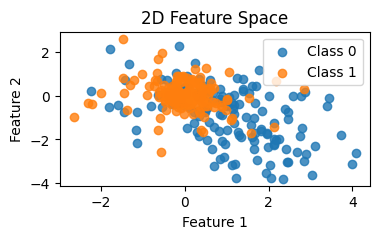

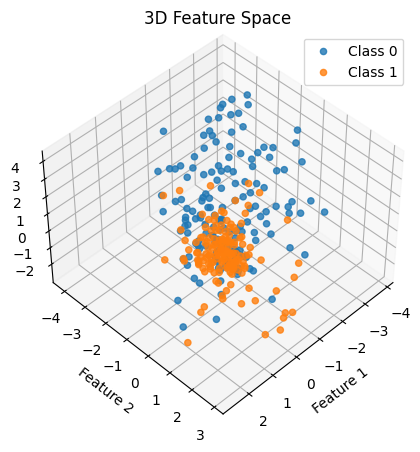

In [140]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# Assuming 'features' is your feature array and 'labels' contains the class labels
class_0 = extracted_features[labels == 0]
class_1 = extracted_features[labels == 1]

# 2D Plot
plt.figure(figsize=(4, 2))
plt.scatter(class_0[:,2], class_0[:, 1], alpha=0.8, label='Class 0')
plt.scatter(class_1[:, 2], class_1[:, 1], alpha=0.8, label='Class 1')
plt.title('2D Feature Space')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()


# 3D Plot
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(class_0[:, 1], class_0[:,3], class_0[:, 2], alpha=0.8, label='Class 0')
ax.scatter(class_1[:, 1], class_1[:, 3], class_1[:, 2], alpha=0.8, label='Class 1')
# Set the viewpoint
elevation_angle =45# adjust this for up/down rotation (in degrees)
azimuth_angle =45 # adjust this for left/right rotation (in degrees)
ax.view_init(elev=elevation_angle, azim=azimuth_angle)
ax.set_title('3D Feature Space')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
ax.legend()
plt.show()

In [141]:
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.fft import fft
c=(50/1000)
W_1= (int(0*c),int(50*c))
W_2= (int(80*c),int(210*c))
W_3= (int(240*c),int(350*c)) 
W_4= (int(400*c),int(500*c)) 
W_5= (int(520*c),int(630*c)) 
W_6= (int(650*c),int(900*c))
W_7= (int(0*c),int(1000*c)) 

def extract_ERP_features(epoch):
    def extract_window_features(window):
        amplitude_max = np.max(window)
        amplitude_min = np.min(window)
        mean_amplitude = np.mean(window)
        variance = np.var(window)
        std_deviation = np.std(window)
        skewness = skew(window)
        kurt = kurtosis(window)
        peak_to_peak_amplitude = amplitude_max - amplitude_min
        zero_crossings = np.where(np.diff(np.sign(window)))[0].size
        
        # Find peaks
        peaks, _ = find_peaks(window)
        # print(peaks)
        number_of_peaks = len(peaks)
        
        # # Calculate peak latencies
        # latency = (peak_index / sampling_rate) * 1000
        peak_latencies = [peak / 50 * 1000 for peak in peaks]  # Replace 'sampling_rate' with your actual rate
        
        # Frequency domain features (e.g., dominant frequency)
        freq_data = fft(window)
        dominant_frequency = np.argmax(np.abs(freq_data))

        return [mean_amplitude, variance, std_deviation, 
                peak_to_peak_amplitude, zero_crossings, number_of_peaks ]

    W1_region = epoch[W_1[0]:W_1[1]]
    W2_region = epoch[W_2[0]:W_2[1]]
    W3_region = epoch[W_3[0]:W_3[1]]
    W4_region = epoch[W_4[0]:W_4[1]]
    W5_region = epoch[W_5[0]:W_5[1]]
    W6_region = epoch[W_6[0]:W_6[1]]
    W7_region = epoch[W_7[0]:W_7[1]]

    W1_features = extract_window_features(W1_region)
    W2_features = extract_window_features(W2_region)
    W3_features = extract_window_features(W3_region)
    W4_features = extract_window_features(W4_region)
    W5_features = extract_window_features(W5_region)
    W6_features = extract_window_features(W6_region)
    W7_features = extract_window_features(W7_region)

    return W1_features + W2_features + W3_features + W4_features + W5_features + W6_features  + W7_features


In [142]:
num_runs, num_trials_per_run, num_samples, num_channels =  ERP_np_eeg.shape
ERP_epoch_EEG = ERP_np_eeg.reshape(num_runs * num_trials_per_run, num_samples, num_channels)

ERP_TEPM_FEATURE=[]
for i in range(len(ERP_epoch_EEG)):
    ERP_W=[]
    for j in range( num_channels):
        ERP_W_CH=extract_ERP_features(ERP_epoch_EEG[i,:,j])
        ERP_W.append(ERP_W_CH)
    ERP_W_np=np.array(ERP_W)
    ERP_TEPM_FEATURE.append(ERP_W_np)

ERP_TEPM_FEATURE_np=np.array(ERP_TEPM_FEATURE)



In [143]:
ERP_TEPM_FEATURE_np.shape

(320, 8, 42)

In [144]:
combined_features = np.concatenate([hilbert_feature_matrix, wavelet_feature_array, LDA_ERP, ERP_TEPM_FEATURE_np], axis=2)  # ERP_TEPM_FEATURE_np ,LDA_ERP, hilbert_feature_matrix, ERP_matrices_np,wavelet_feature_matrix
combined_features.shape

##########################################################################################################################
#Input to the classifier
mlp_data=combined_features.reshape(combined_features.shape[0], combined_features.shape[1]*combined_features.shape[2])
print('mlp_data.shape', mlp_data.shape)

af_mlp=mlp_data
Y_mlp=label_final_np_squeeze

print(af_mlp.shape, Y_mlp.shape)
af_mlp, Y_mlp= shuffle(af_mlp, Y_mlp)
print(af_mlp.shape, Y_mlp.shape)

#############################################################################################################################
X_train= af_mlp
y_train=Y_mlp


mlp_data.shape (320, 640)
(320, 640) (320,)
(320, 640) (320,)


In [147]:
import optuna
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

def objective(trial):
    # Suggest values for the hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 2, 10)
    max_depth = trial.suggest_int('max_depth', 5, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2,20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 5)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    # Create the random forest classifier with suggested values
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        criterion=criterion,
        random_state=42
    )

    # K-fold cross-validation
    accuracies = cross_val_score(clf, X_train, y_train, n_jobs=-1, cv=5)

    # Compute the average accuracy
    average_accuracy = np.mean(accuracies)
    return average_accuracy

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Get the best parameters
best_params = study.best_params
print('Best parameters:', best_params)
best_score = study.best_value
print(f'Best model accuracy: {best_score}')

# Create and fit the model with the best parameters
clf = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    criterion=best_params['criterion'],
    random_state=42
)
clf.fit(X_train, y_train)

[I 2024-02-01 13:33:11,926] A new study created in memory with name: no-name-5ed7b6fd-d41a-4f45-8d26-63098beaa2b6
[I 2024-02-01 13:33:12,223] Trial 0 finished with value: 0.75625 and parameters: {'n_estimators': 7, 'max_depth': 19, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 'auto', 'criterion': 'gini'}. Best is trial 0 with value: 0.75625.
[I 2024-02-01 13:33:12,423] Trial 1 finished with value: 0.740625 and parameters: {'n_estimators': 3, 'max_depth': 17, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 0 with value: 0.75625.
[I 2024-02-01 13:33:12,607] Trial 2 finished with value: 0.75 and parameters: {'n_estimators': 10, 'max_depth': 18, 'min_samples_split': 12, 'min_samples_leaf': 5, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 0 with value: 0.75625.
[I 2024-02-01 13:33:12,748] Trial 3 finished with value: 0.75625 and parameters: {'n_estimators': 5, 'max_depth': 18, 'min_samples_split':

Best parameters: {'n_estimators': 9, 'max_depth': 5, 'min_samples_split': 20, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'criterion': 'gini'}
Best model accuracy: 0.815625


RandomForestClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=20,
                       n_estimators=9, random_state=42)

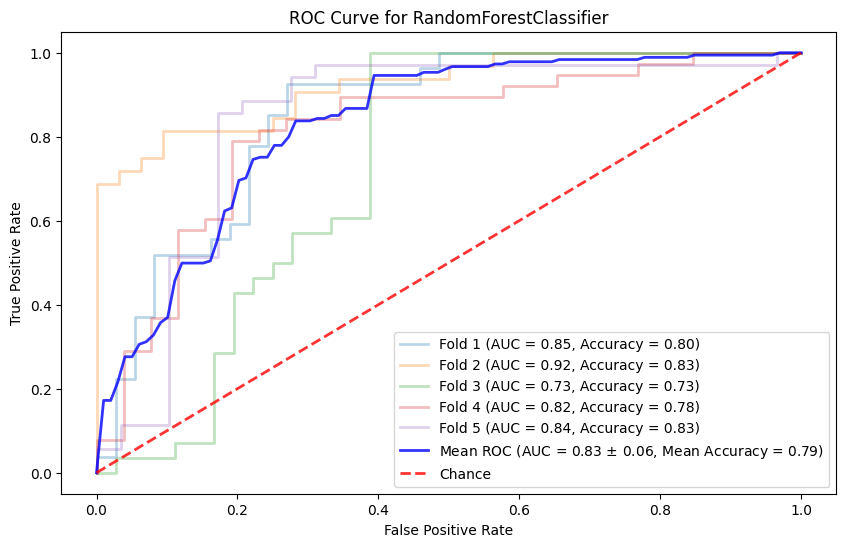

Mean CV accuracy: 0.79375


In [153]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.metrics import classification_report

# Assuming you have your features as X_train and target variable as y_train
# Assuming you have determined the best hyperparameters (best_params) using Optuna or another hyperparameter optimization framework
best_params = study.best_trial.params

# Initialize the classifier with the best parameters
clf = RandomForestClassifier(**best_params, random_state=42)

# Set up k-fold cross-validation
num_folds = 5
kf = KFold(n_splits=num_folds)

# Lists to store metrics for each fold
tprs = []
aucs = []
accuracies = []
mean_fpr = np.linspace(0, 1, 100)

# Plotting setup
plt.figure(figsize=(10,6))

# Perform K-Fold CV
for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Train the model
    clf.fit(X_train_fold, y_train_fold)

    # Predict probabilities
    y_proba_fold = clf.predict_proba(X_val_fold)[:, 1]

    # Compute ROC curve and AUC for this fold
    fpr, tpr, thresholds = roc_curve(y_val_fold, y_proba_fold)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    # Compute and store the accuracy for this fold
    fold_accuracy = accuracy_score(y_val_fold, clf.predict(X_val_fold))
    accuracies.append(fold_accuracy)

    # Plot ROC curve for this fold
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label=f'Fold {fold+1} (AUC = {roc_auc:.2f}, Accuracy = {fold_accuracy:.2f})')

    # Interpolate TPR for mean ROC
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0  # Ensure the curve starts at 0
    tprs.append(interp_tpr)

# Calculate mean TPR and AUC
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
mean_accuracy = np.mean(accuracies)
std_auc = np.std(aucs)

# Plot the average ROC curve
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f, Mean Accuracy = %0.2f)' % (mean_auc, std_auc, mean_accuracy),
         lw=2, alpha=0.8)

# Plot luck line
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)

# Decorate the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for RandomForestClassifier')
plt.legend(loc='lower right')
plt.show()

# Print the mean accuracy across all folds
print(f"Mean CV accuracy: {mean_accuracy}")


In [22]:
from joblib import dump, load

# Save the model
dump(clf, 'random_forest_model.joblib')


['random_forest_model.joblib']

In [145]:
import optuna
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold

def objective(trial):
    C = trial.suggest_float('C', 1e-3, 1e3, log=True)
    gamma = trial.suggest_float('gamma', 1e-3, 1e3, log=True)
    
    # Define a pipeline to ensure scaling is done within each CV fold
    svc = Pipeline([
        ('scaler', StandardScaler()),
        ('svc', SVC(C=C, gamma=gamma, kernel='rbf', class_weight='balanced', random_state=42))
    ])
    
    # Use stratified K-Fold to maintain class distribution
    stratified_cv = StratifiedKFold(n_splits=10)
    
    # Obtain the cross-validation score
    score_svm = cross_val_score(svc, X_train, y_train, n_jobs=-1, cv=stratified_cv).mean()
    return score_svm

study_svm = optuna.create_study(direction='maximize')
study_svm.optimize(objective, n_trials=100)

# After the study, print the best parameters and their corresponding score
best_params_svm = study_svm.best_params
best_score_svm= study_svm.best_value
print(f'Best parameters found: {best_params_svm}')
print(f'Best cross-validation score: {best_score_svm}')

# Train the model with the best parameters on the scaled data
best_model_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(**best_params_svm, kernel='rbf', class_weight='balanced', random_state=42))
])
best_model_svm.fit(X_train, y_train)

# Optionally, you can save the trained model or return it
# Save the model
# joblib.dump(best_model, 'best_svc_model.pkl')
# return best_model


[I 2024-02-01 13:32:23,191] A new study created in memory with name: no-name-88fa4df3-f6f0-4e5f-9eeb-83963a020c04
[I 2024-02-01 13:32:25,558] Trial 0 finished with value: 0.5 and parameters: {'C': 7.9329015629979365, 'gamma': 50.58517729462315}. Best is trial 0 with value: 0.5.
[I 2024-02-01 13:32:25,803] Trial 1 finished with value: 0.721875 and parameters: {'C': 0.00266055259040168, 'gamma': 0.3172802887914159}. Best is trial 1 with value: 0.721875.
[I 2024-02-01 13:32:26,056] Trial 2 finished with value: 0.625 and parameters: {'C': 0.8452514655614835, 'gamma': 0.007082009318782013}. Best is trial 1 with value: 0.721875.
[I 2024-02-01 13:32:26,318] Trial 3 finished with value: 0.7125 and parameters: {'C': 159.80219576612592, 'gamma': 0.670034638797807}. Best is trial 1 with value: 0.721875.
[I 2024-02-01 13:32:26,584] Trial 4 finished with value: 0.64375 and parameters: {'C': 177.71901256901398, 'gamma': 0.7991996991655061}. Best is trial 1 with value: 0.721875.
[I 2024-02-01 13:32:2

Best parameters found: {'C': 641.186061488649, 'gamma': 0.0011656100977996814}
Best cross-validation score: 0.85625


Pipeline(steps=[('scaler', StandardScaler()),
                ('svc',
                 SVC(C=641.186061488649, class_weight='balanced',
                     gamma=0.0011656100977996814, random_state=42))])

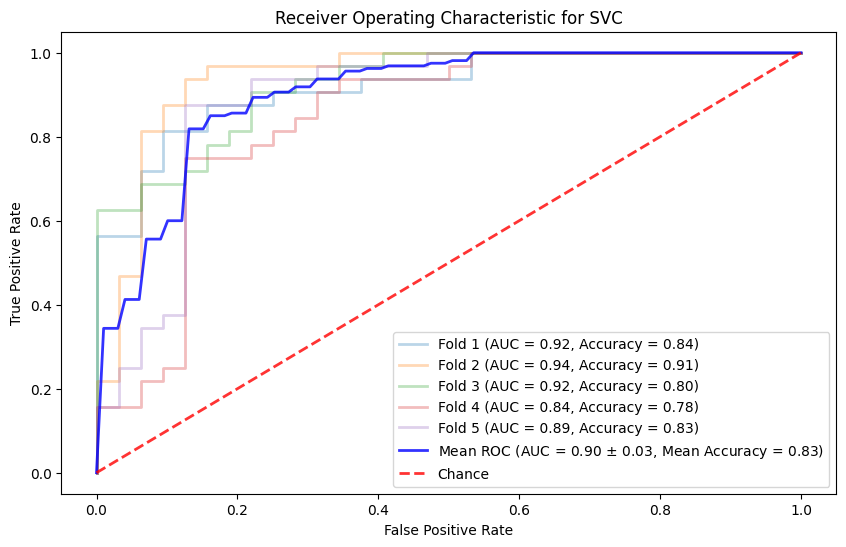

Mean accuracy: 0.83125


In [152]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, accuracy_score

# Assuming X_train, y_train are defined and study.best_params has been set
best_params_svm = study_svm.best_params
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

tprs_svm = []
aucs_svm = []
accuracies_svm = []  # List to store accuracy for each fold
mean_fpr_svm = np.linspace(0, 1, 100)

plt.figure(figsize=(10, 6))

for fold, (train_index, test_index) in enumerate(stratified_cv.split(X_train, y_train)):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

    # Create and fit the model on the training fold
    model_svm = Pipeline([
        ('scaler', StandardScaler()),
        ('svc', SVC(**best_params_svm, kernel='rbf', class_weight='balanced', probability=True, random_state=42))
    ])
    model_svm.fit(X_train_fold, y_train_fold)

    # Predict probabilities
    probs_svm = model_svm.predict_proba(X_test_fold)[:, 1]

    # Compute ROC curve and area under the curve
    fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test_fold, probs_svm)
    roc_auc_svm = auc(fpr_svm, tpr_svm)
    aucs_svm.append(roc_auc_svm)

    # Calculate and store the accuracy for this fold
    fold_accuracy_svm = accuracy_score(y_test_fold, model_svm.predict(X_test_fold))
    accuracies_svm.append(fold_accuracy_svm)

    # Plot ROC curve for this fold
    plt.plot(fpr_svm, tpr_svm, lw=2, alpha=0.3, label=f'Fold {fold+1} (AUC = {roc_auc_svm:.2f}, Accuracy = {fold_accuracy_svm:.2f})')

    # Interpolate all ROC curves at this points
    interp_tpr_svm = np.interp(mean_fpr_svm, fpr_svm, tpr_svm)
    interp_tpr_svm[0] = 0.0
    tprs_svm.append(interp_tpr_svm)

# Plot the mean ROC curve
mean_tpr_svm = np.mean(tprs_svm, axis=0)
mean_tpr_svm[-1] = 1.0
mean_auc_svm = auc(mean_fpr_svm, mean_tpr_svm)
std_auc_svm = np.std(aucs_svm)
mean_accuracy_svm = np.mean(accuracies_svm)  # Mean accuracy across all folds
plt.plot(mean_fpr_svm, mean_tpr_svm, color='blue',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f, Mean Accuracy = %0.2f)' % (mean_auc_svm, std_auc_svm, mean_accuracy_svm),
         lw=2, alpha=0.8)

# Plot the chance line (diagonal line)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='red', label='Chance', alpha=.8)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for SVC')
plt.legend(loc="lower right")
plt.show()

# Print out the mean accuracy
print(f"Mean accuracy: {mean_accuracy_svm}")


c:\Users\Maryam\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Maryam\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


TypeError: 'numpy.float64' object does not support item assignment

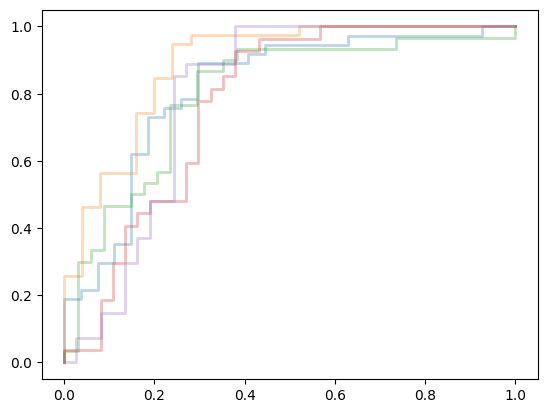

In [149]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Assuming X_train, y_train, study, and study_svm are defined and have been set appropriately

# Best parameters from hyperparameter optimization
best_params_rf = study.best_trial.params
best_params_svm = study_svm.best_params

# Initialize classifiers with the best parameters
clf_rf = RandomForestClassifier(**best_params_rf, random_state=42)
model_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(**best_params_svm, kernel='rbf', probability=True, random_state=42))
])

# Set up cross-validation
kf_rf = KFold(n_splits=5, shuffle=True, random_state=42)
stratified_cv_svm = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Prepare to collect metrics
tprs_rf = []
aucs_rf = []
accuracies_rf = []

tprs_svm = []
aucs_svm = []
accuracies_svm = []

mean_fpr = np.linspace(0, 1, 100)

# Perform K-Fold CV for RF
for train_index, val_index in kf_rf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Train the model
    clf.fit(X_train_fold, y_train_fold)

    # Predict probabilities
    y_proba_fold = clf.predict_proba(X_val_fold)[:, 1]

    # Compute ROC curve and AUC for this fold
    fpr, tpr, thresholds = roc_curve(y_val_fold, y_proba_fold)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    # Compute and store the accuracy for this fold
    fold_accuracy = accuracy_score(y_val_fold, clf.predict(X_val_fold))
    accuracies.append(fold_accuracy)

    # Plot ROC curve for this fold
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label=f'Fold {fold+1} (AUC = {roc_auc:.2f}, Accuracy = {fold_accuracy:.2f})')

    # Interpolate TPR for mean ROC
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0  # Ensure the curve starts at 0
    tprs.append(interp_tpr)

# Calculate mean metrics for RF
mean_tpr_rf = np.mean(tprs_rf, axis=0)
mean_tpr_rf[-1] = 1.0
mean_auc_rf = auc(mean_fpr, mean_tpr_rf)
mean_accuracy_rf = np.mean(accuracies_rf)

# Perform Stratified K-Fold CV for SVM
for train_index, test_index in stratified_cv_svm.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

    # Create and fit the model on the training fold
    model_svm = Pipeline([
        ('scaler', StandardScaler()),
        ('svc', SVC(**best_params_svm, kernel='rbf', class_weight='balanced', probability=True, random_state=42))
    ])
    model_svm.fit(X_train_fold, y_train_fold)

    # Predict probabilities
    probs_svm = model_svm.predict_proba(X_test_fold)[:, 1]

    # Compute ROC curve and area under the curve
    fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test_fold, probs_svm)
    roc_auc_svm = auc(fpr_svm, tpr_svm)
    aucs_svm.append(roc_auc_svm)

    # Calculate and store the accuracy for this fold
    fold_accuracy_svm = accuracy_score(y_test_fold, model_svm.predict(X_test_fold))
    accuracies_svm.append(fold_accuracy_svm)

    # Plot ROC curve for this fold
    plt.plot(fpr_svm, tpr_svm, lw=2, alpha=0.3, label=f'Fold {fold+1} (AUC = {roc_auc_svm:.2f}, Accuracy = {fold_accuracy_svm:.2f})')

    # Interpolate all ROC curves at this points
    interp_tpr_svm = np.interp(mean_fpr_svm, fpr_svm, tpr_svm)
    interp_tpr_svm[0] = 0.0
    tprs_svm.append(interp_tpr_svm)

# Calculate mean metrics for SVM
mean_tpr_svm = np.mean(tprs_svm, axis=0)
mean_tpr_svm[-1] = 1.0
mean_auc_svm = auc(mean_fpr, mean_tpr_svm)
mean_accuracy_svm = np.mean(accuracies_svm)

# Plotting setup
plt.figure(figsize=(10, 6))

# Plot the mean ROC curves
plt.plot(mean_fpr, mean_tpr_rf, color='green',
         label='RF Mean ROC (AUC = {:.2f}, Mean Accuracy = {:.2f})'.format(mean_auc_rf, mean_accuracy_rf),
         lw=2, alpha=0.8)

plt.plot(mean_fpr, mean_tpr_svm, color='blue',
         label='SVM Mean ROC (AUC = {:.2f} $\pm$ {:.2f}, Mean Accuracy = {:.2f})'.format(mean_auc_svm, np.std(aucs_svm), mean_accuracy_svm),
         lw=2, alpha=0.8)

# Plot the chance line
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='red', label='Chance', alpha=0.8)

# Decorate the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC Curves for RF and SVM')
plt.legend(loc="lower right")
plt.show


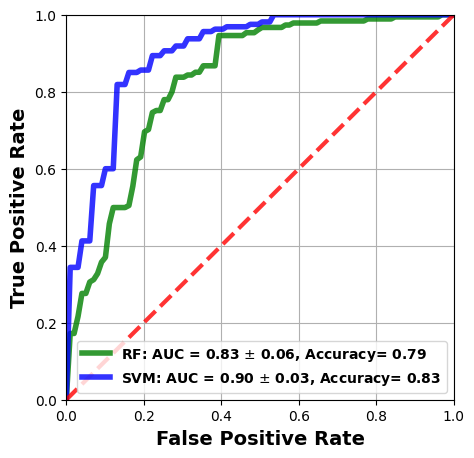

In [235]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc


# Plot the mean ROC curves
plt.figure(figsize=(5,5))
plt.plot(mean_fpr, mean_tpr, color='green',
         label=f'RF: AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f}, Accuracy= {mean_accuracy:.2f}',
         lw=4, alpha=0.8)

plt.plot(mean_fpr_svm, mean_tpr_svm, color='blue',
         label=f'SVM: AUC = {mean_auc_svm:.2f} $\pm$ {std_auc_svm:.2f}, Accuracy= {mean_accuracy_svm:.2f}',
         lw=4, alpha=0.8)

plt.plot([0, 1], [0, 1], linestyle='--', lw=3, color='red', alpha=.8)

plt.xlabel('False Positive Rate', weight='bold', fontsize=14)
plt.ylabel('True Positive Rate',weight='bold', fontsize=14)
# plt.title('Mean ROC Curves for RF and SVM Classifiers')
plt.legend(loc="lower right")
legend = plt.legend(loc="lower right")
for text in legend.get_texts():
    text.set_weight('bold')
plt.xlim(0, 1)  # Set x-axis limit
plt.ylim(0, 1)  # Set y-axis limit
plt.grid(True)
plt.show()


In [30]:
from sklearn.model_selection import StratifiedKFold

# Retrieve the best hyperparameters
best_params = study.best_params
best_score = study.best_value
print(f'Best parameters found: {best_params}')
print(f'Best cross-validation score: {best_score}')

# Initialize StratifiedKFold
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store results of each fold
accuracies = []
best_models = []

for fold, (train_index, test_index) in enumerate(stratified_cv.split(X_train, y_train)):
    # Split data
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

    # Define the pipeline with the best parameters
    best_model = Pipeline([
        ('scaler', StandardScaler()),
        ('svc', SVC(**best_params, kernel='rbf', class_weight='balanced', random_state=42))
    ])

    # Fit the model on the training fold
    best_model.fit(X_train_fold, y_train_fold)
    
    # Save the model trained on this fold
    best_models.append(best_model)
    
    # Evaluate the model on the validation fold
    score = best_model.score(X_test_fold, y_test_fold)
    accuracies.append(score)
    print(f'Fold {fold + 1} accuracy: {score}')

# Calculate and print the mean accuracy across all folds
mean_accuracy = np.mean(accuracies)
print(f'Mean CV accuracy: {mean_accuracy}')


Best parameters found: {'C': 672.0010707614049, 'gamma': 0.0020055744718619757}
Best cross-validation score: 0.728125
Fold 1 accuracy: 0.65625
Fold 2 accuracy: 0.71875
Fold 3 accuracy: 0.75
Fold 4 accuracy: 0.671875
Fold 5 accuracy: 0.6875
Mean CV accuracy: 0.696875


In [180]:
# Train the final model on the full dataset
final_model = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(**best_params, kernel='rbf', class_weight='balanced', random_state=42))
])
final_model.fit(X_train, y_train)

# Save the final model
dump(final_model, 'final_svc_model.joblib')



['final_svc_model.joblib']

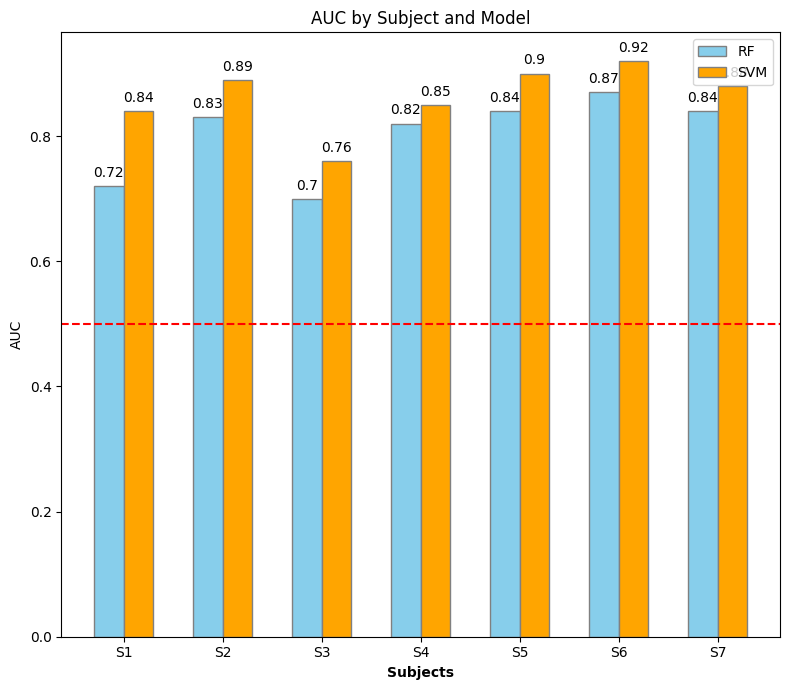

In [193]:
import matplotlib.pyplot as plt
import numpy as np

# Define the AUC values for each subject and model
rf_auc_values = [0.72, 0.83, 0.7, 0.82, 0.84, 0.87, 0.84]
svm_auc_values = [0.84, 0.89, 0.76, 0.85, 0.90, 0.92, 0.88]

# Labels for the groups
subjects = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7']

# The x position of bars
barWidth = 0.3
r1 = np.arange(len(rf_auc_values))
r2 = [x + barWidth for x in r1]


        
# Create the bar plots
plt.figure(figsize=(8,7))
rf_bars = plt.bar(r1, rf_auc_values, color='skyblue', width=barWidth, edgecolor='grey', label='RF')
svm_bars = plt.bar(r2, svm_auc_values, color='orange', width=barWidth, edgecolor='grey', label='SVM')

for bars in [rf_bars, svm_bars]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', va='bottom')
# plt.bar(r1, rf_auc_values, color='skyblue', width=barWidth, edgecolor='grey', label='RF')
# plt.bar(r2, svm_auc_values, color='orange', width=barWidth, edgecolor='grey', label='SVM')

# Add labels and title
plt.xlabel('Subjects', fontweight='bold')
plt.ylabel('AUC')
plt.xticks([r + barWidth / 2 for r in range(len(rf_auc_values))], subjects)
plt.title('AUC by Subject and Model')

# Create legend & Show graphic
plt.legend()
plt.axhline(y=0.5, color='red', linestyle='--') # Chance line
plt.tight_layout()

# Save the plot
plt.savefig('auc_chart.png')

# Display the plot
plt.show()


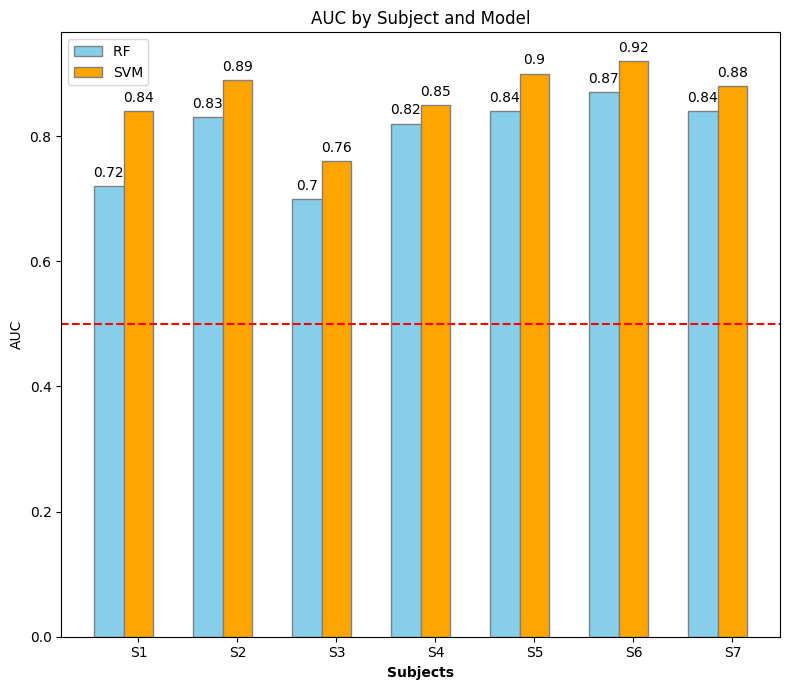

In [199]:
import matplotlib.pyplot as plt
import numpy as np

# Define the accuracy values for each subject and model
rf_auc_values = [0.72, 0.83, 0.7, 0.82, 0.84, 0.87, 0.84]
svm_auc_values = [0.84, 0.89, 0.76, 0.85, 0.90, 0.92, 0.88]

# Labels for the groups
subjects = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7']

# The x position of bars
barWidth = 0.3
r1 = np.arange(len(rf_auc_values))
r2 = [x + barWidth for x in r1]

# Create the bar plots
plt.figure(figsize=(8, 7))

rf_bars = plt.bar(r1, rf_auc_values, color='skyblue', width=barWidth, edgecolor='grey', label='RF ')
svm_bars = plt.bar(r2, svm_auc_values, color='orange', width=barWidth, edgecolor='grey', label='SVM')

# Add labels and title
plt.xlabel('Subjects', fontweight='bold')
plt.ylabel('AUC')
plt.xticks([r + barWidth for r in range(len(rf_auc_values))], subjects)
plt.title('AUC by Subject and Model')

# Annotate the accuracy values above the bars
for bars in [rf_bars, svm_bars]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# Create legend on the left side of the plot
plt.legend(loc='upper left')  # You can change 'upper left' to 'lower left' if preferred

plt.axhline(y=0.5, color='red', linestyle='--') # Chance line
plt.tight_layout()

plt.tight_layout()

# Save the figure if needed
plt.savefig('AUC_bar_plot.png')

# Display the plot
plt.show()


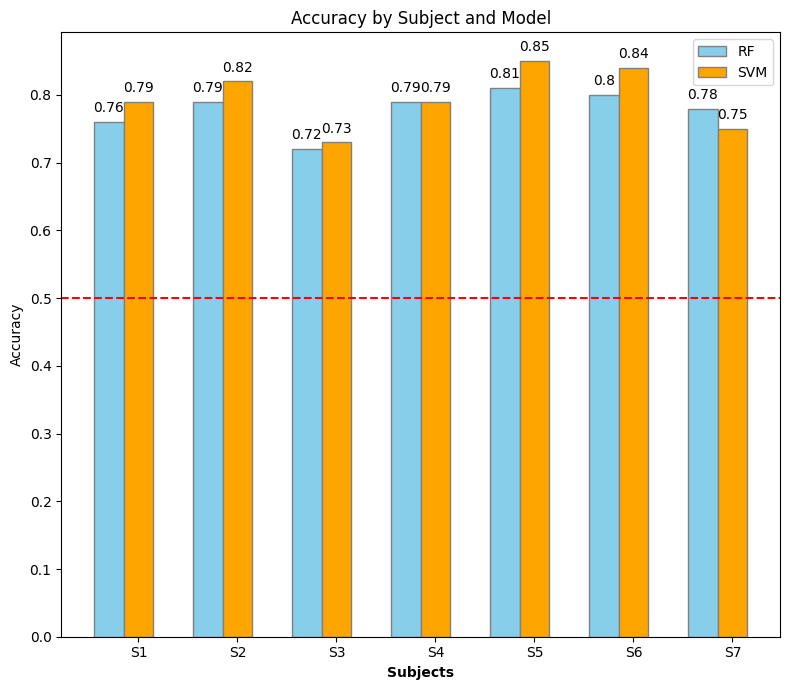

In [200]:
import matplotlib.pyplot as plt
import numpy as np

# Define the accuracy values for each subject and model
rf_accuracy_values = [0.76, 0.79, 0.72, 0.79, 0.81, 0.80, 0.78]
svm_accuracy_values = [0.79, 0.82, 0.73, 0.79, 0.85, 0.84, 0.75]

# Labels for the groups
subjects = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7']

# The x position of bars
barWidth = 0.3
r1 = np.arange(len(rf_accuracy_values))
r2 = [x + barWidth for x in r1]

# Create the bar plots
plt.figure(figsize=(8, 7))

rf_bars = plt.bar(r1, rf_accuracy_values, color='skyblue', width=barWidth, edgecolor='grey', label='RF')
svm_bars = plt.bar(r2, svm_accuracy_values, color='orange', width=barWidth, edgecolor='grey', label='SVM')

# Add labels and title
plt.xlabel('Subjects', fontweight='bold')
plt.ylabel('Accuracy')
plt.xticks([r + barWidth for r in range(len(rf_accuracy_values))], subjects)
plt.title('Accuracy by Subject and Model')

# Annotate the accuracy values above the bars
for bars in [rf_bars, svm_bars]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

# Create legend & Show graphic
plt.legend()
plt.tight_layout()
plt.axhline(y=0.5, color='red', linestyle='--') # Chance line
plt.tight_layout()
# Save the figure if needed
plt.savefig('accuracy_bar_plot.png')

# Display the plot
plt.show()
